# [cknowledge.org/ai](http://cknowledge.org/ai): Crowdsourcing benchmarking and optimisation of AI

# [PUBLIC] Benchmarking Caffe and TensorRT on NVIDIA Jetson TX1

**NB:** The Caffe results are released with approval from General Motors. The TensorRT 1.0 EA results are released with approval from NVIDIA.

## Table of Contents

1. [Overview](#overview)
1. [See the code](#code) [for developers]
1. [Get the data](#data) [for developers]
1. [See the tables](#tables)
  1. [All data](#df_all)
  1. [All execution time data](#df_time)
  1. [Mean execution time per batch](#df_mean_time_per_batch)
  1. [Mean execution time per image](#df_mean_time_per_image)
  1. [Best mean execution time per image](#df_best_mean_time_per_image)
1. [See the graphs - grouped by models](#plot_models)
  1. [All libs](#plot_models_all)
  1. [GPU libs](#plot_models_gpu)
  1. [CUDA-level performance libs](#plot_models_cuda)
  1. [cuBLAS libs](#plot_models_cublas)
  1. [cuDNN libs](#plot_models_cudnn)
  1. [TensorRT engine](#plot_models_tensorrt)
1. [See the graphs - grouped by libs](#plot_libs)
  1. [All models](#plot_libs_all)
  1. [All models, GPU libs](#plot_libs_gpu)
  1. [Models with AlexNet-level accuracy](#plot_libs_alexnet)
  1. [Models with AlexNet-level accuracy, CPU lib](#plot_libs_alexnet_cpu) 
  1. [Models with AlexNet-level accuracy, CUDA-level perfomance libs](#plot_libs_alexnet_cuda)
  1. [Models with AlexNet-level accuracy, fp16 libs](#plot_libs_alexnet_fp16)
  1. [GoogleNet, fp16 libs](#plot_libs_googlenet_fp16)
1. [See the graphs - per layer execution time profiling](#plot_per_layer)
1. [See the graphs - the ideal adaptive solution](#plot_ideal)
  1. [Using all libs for adaptation](#plot_ideal_all)
  1. [Using CUDA-level performance libs for adaptation](#plot_ideal_cuda)
  1. [Using cuDNN and cuBLAS for adaptation](#plot_ideal_cudnn_cublas)
  1. [Using cuDNN and libDNN for adaptation](#plot_ideal_cudnn_libdnn)
1. [See the memory consumption graph](#plot_memory)
  1. [Balance memory consumption and execution time per image](#balance_memory_time)
1. [Compare AlexNet and SqueezeNet 1.1](#alexnet_vs_squeezenet)
  1. [Compare memory consumption](#alexnet_vs_squeezenet_memory)
  1. [Compare execution time](#alexnet_vs_squeezenet_time)
1. [Conclusion](#conclusion)
  1. [What are the improvements brought on by each approach?](#improvements_of_each_approach)
  1. [How do dividiti's results compare with NVIDIA's results in the whitepaper?](#compare_with_whitepaper)
  1. [How does TX1 compare to Myriad2?](#tx1_vs_myriad2)
1. [Crowdsourcing benchmarking and optimisation of AI](#cknowledge_ai)

<a id="overview"></a>
## Overview

This Jupyter Notebook compares the performance (execution time, memory consumption):
- on **[dividiti](http://dividiti.com)**'s Jetson TX1 board ([official page](http://www.nvidia.com/object/jetson-tx1-dev-kit.html), [Phoronix review](http://www.phoronix.com/scan.php?page=article&item=nvidia-jtx1-perf)):
  - CPU:
    - ARM&reg; Cortex&reg;-A57 architecture ("big");
    - 4 cores;
    - Max clock 1743 MHz;
  - GPU:
    - Maxwell&trade; architecture;
    - 256 CUDA cores;
    - Max clock 998 MHz;
  - RAM:
    - LPDDR4;
    - 4 GB (shared between the CPU and the GPU);
    - Max bandwidth 25.6 GB/s;
  - [Linux for Tegra 24.2.1](http://developer.download.nvidia.com/embedded/L4T/r24_Release_v2.1/Docs/Tegra_Linux_Driver_Package_Release_Notes_R24.2.1.pdf);
  - [JetPack 2.3.1](http://docs.nvidia.com/jetpack-l4t/index.html#developertools/desktop/jetpack/l4t/2.3.1);
  - CUDA Toolkit 8.0.33.
```
$ uname -a
Linux tegra-ubuntu 3.10.96-tegra #1 SMP PREEMPT Wed Nov 9 19:42:57 PST 2016 aarch64 aarch64 aarch64 GNU/Linux
$ cat /etc/lsb-release
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=16.04
DISTRIB_CODENAME=xenial
DISTRIB_DESCRIPTION="Ubuntu 16.04.1 LTS"
```

- using 6 Caffe **libraries**:
  - [`tag`] **Branch** (**revision hash, date**): **math libraries**.
  - [`cpu`] Master ([24d2f67](https://github.com/BVLC/caffe/commit/24d2f67173db3344141dce24b1008efffbfe1c7d), 28/Nov/2016): with [OpenBLAS 0.2.19](https://github.com/xianyi/OpenBLAS/releases/tag/v0.2.19);
  - [`nvidia-cuda`] NVIDIA 0.15 ([1024d34](https://github.com/NVIDIA/caffe/commit/1024d34d93cd34a9013d6fac4e56e45162073d38), 17/Nov/2016): with [cuBLAS](https://developer.nvidia.com/cublas) (part of CUDA Toolkit 8.0.33);
  - [`nvidia-cudnn`] NVIDIA 0.15 ([1024d34](https://github.com/NVIDIA/caffe/commit/1024d34d93cd34a9013d6fac4e56e45162073d38), 17/Nov/2016): with [cuDNN 5.1](https://developer.nvidia.com/cudnn);
  - [`nvidia-fp16-cuda`] NVIDIA experimental/fp16 ([fca1cf4](https://github.com/NVIDIA/caffe/commit/fca1cf475d1d0a6d355f8b9877abcc4e13951c9c), 11/Jul/2016): with [cuBLAS](https://developer.nvidia.com/cublas) (part of CUDA Toolkit 8.0.33);
  - [`nvidia-fp16-cudnn`] NVIDIA experimental/fp16 ([fca1cf4](https://github.com/NVIDIA/caffe/commit/fca1cf475d1d0a6d355f8b9877abcc4e13951c9c), 11/Jul/2016): with [cuDNN 5.1](https://developer.nvidia.com/cudnn);
  - [`libdnn-cuda`] OpenCL ([b735c2d](https://github.com/BVLC/caffe/commit/b735c2dd4103ac963332b400168507dd7cefd204), 23/Nov/2016): with [libDNN](https://github.com/BVLC/caffe/issues/4155) and [cuBLAS](https://developer.nvidia.com/cublas) (part of CUDA Toolkit 8.0.33) for fully connected layers;
  <br>
  **NB:** libDNN is not yet tuned for TX1 - it uses parameters that are optimal for GTX 1080.

- using 2 configurations of the [NVIDIA TensorRT 1.0.0 EA engine](https://developer.nvidia.com/tensorrt):
  - [`tensorrt-fp16`] NVIDIA TensorRT 1.0.0 EA with fp16 enabled;
  - [`tensorrt-fp32`] NVIDIA TensorRT 1.0.0 EA with fp16 disabled;
  <br>
  **NB:** This EA ("early access") version is used in accordance with special licensing terms: the results are released with explicit written approval from NVIDIA. The results may not be representative of the GA ("general availability") version.

- using 4 CNN **models**:
  - [GoogleNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet);
  - [AlexNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet);
  - [SqueezeNet 1.0](https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.0);
  - [SqueezeNet 1.1](https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1);

- with the **batch size** varying from 2 to 16 with step 2.

### Configure the execution time metric to use

In [1]:
fw = [ 'forward' ]
fwbw = [ 'forward', 'backward' ]

In [2]:
# Set to fw for inference; to fwbw for training.
direction = fw
direction

['forward']

In [3]:
if direction==fw:
    time_ms = 'time_fw_ms'
else: # direction==fwbw
    time_ms = 'time_fwbw_ms'
time_ms

'time_fw_ms'

In [4]:
def images_per_second(time_in_milliseconds):
    return 1000.0 / time_in_milliseconds

<a id="code"></a>
## Data wrangling code

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook.

### Includes

#### Standard

In [5]:
import os
import sys
import json
import re

#### Scientific

If some of the scientific packages are missing, please install them using:
```
# pip install jupyter pandas numpy matplotlib
```

In [6]:
import IPython as ip
import pandas as pd
import numpy as np
import matplotlib as mp

In [7]:
print ('IPython version: %s' % ip.__version__)
print ('Pandas version: %s' % pd.__version__)
print ('NumPy version: %s' % np.__version__)
print ('Matplotlib version: %s' % mp.__version__)

IPython version: 4.1.1
Pandas version: 0.19.1
NumPy version: 1.11.2
Matplotlib version: 1.5.3


In [8]:
from IPython.display import Image
from IPython.core.display import HTML

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [10]:
default_title = 'NVIDIA Jetson TX1'
default_ylabel = 'Execution time (ms)'
default_colormap = cm.autumn
default_fontsize = 16
default_figsize = [16, 8]

#### Collective Knowledge

If CK is not installed, please install it using:
```
# pip install ck
```

In [11]:
import ck.kernel as ck
print ('CK version: %s' % ck.__version__)

CK version: 1.8.7.1


### Access the experimental data

In [12]:
repo_uoa = 'ck-caffe-nvidia-tx1'

In [13]:
def get_experimental_results(repo_uoa, tags):
    module_uoa = 'experiment'
    r = ck.access({'action':'search', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'tags':tags})
    if r['return']>0:
        print ("Error: %s" % r['error'])
        exit(1)
    experiments = r['lst']
    
    dfs = []
    for experiment in experiments:
        data_uoa = experiment['data_uoa']
        r = ck.access({'action':'list_points', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'data_uoa':data_uoa})
        if r['return']>0:
            print ("Error: %s" % r['error'])
            exit(1)

        # Get (lib_tag, model_tag) from a list of tags that should be available in r['dict']['tags'].
        # Tags include 2 of the 3 irrelevant tags, a model tag and a lib tag.
        # NB: Since it's easier to list all model tags than all lib tags, the latter list is not expicitly specified.
        tags = r['dict']['tags']
        irrelevant_tags = [ 'explore-batch-size-libs-models','time_gpu','time_cpu','time_gpu_fp16' ]
        model_tags = [ 'bvlc-alexnet','bvlc-googlenet','deepscale-squeezenet-1.0','deepscale-squeezenet-1.1' ]
        lib_model_tags = [ tag for tag in tags if tag not in irrelevant_tags ]
        model_tags = [ tag for tag in lib_model_tags if tag in model_tags ]
        lib_tags = [ tag for tag in lib_model_tags if tag not in model_tags ]
        if len(lib_tags)==1 and len(model_tags)==1:
            (lib, model) = (lib_tags[0], model_tags[0])
        else:
            continue
        
        for point in r['points']:
            with open(os.path.join(r['path'], 'ckp-%s.0001.json' % point)) as point_file:
                point_data_raw = json.load(point_file)
                # Obtain column data.
                characteristics = [
                    {
                        'time (ms)'   : characteristics['run'].get(time_ms,+1e9), # "positive infinity"
                        'memory (MB)' : characteristics['run'].get('memory_mbytes',-1),
                        'success?'    : characteristics['run'].get('run_success','n/a'),
                        'per layer info' : characteristics['run'].get('per_layer_info',[])
                    }
                    for characteristics in point_data_raw['characteristics_list'] 
                ]
                # Deal with missing column data (resulting from failed runs).
                if len(characteristics)==1:
                    repetitions = point_data_raw['features'].get('statistical_repetitions',1)
                    characteristics = characteristics * repetitions
                # Construct a DataFrame.
                df = pd.DataFrame(characteristics)
                # Set columns and index names.
                df.columns.name = 'run characteristic'
                df.index.name = 'repetition'
                # Set indices.
                if lib=='tensorrt-1.0.0':
                    enable_fp16 = (point_data_raw['choices']['env']['CK_TENSORRT_ENABLE_FP16'] != 0)
                    df['lib'] = 'tensorrt-fp%d' % (16 if enable_fp16 else 32)
                else:
                    df['lib'] = lib
                df['model'] = model
                df['batch size'] = point_data_raw['choices']['env']['CK_CAFFE_BATCH_SIZE']
                df = df.set_index(['lib', 'model', 'batch size'], append=True)
                df = df.reorder_levels(('model', 'lib', 'batch size', 'repetition'))
                # Append to the list of similarly constructed DataFrames.
                dfs.append(df)
    # Concatenate all constructed DataFrames (i.e. stack on top of each other).
    result = pd.concat(dfs)
    return result.sortlevel(result.index.names)

### Plot execution time per image or memory consumption

In [14]:
def plot(mean, std, title=default_title, ylabel=default_ylabel, rot=0, ymax=0):
    ymax = mean.max().max() if ymax==0 else ymax
    ax = mean.plot(kind='bar', yerr=std, grid=True, legend=True, rot=rot, ylim=[0,ymax*1.05],
                   fontsize=default_fontsize, figsize=default_figsize, colormap=default_colormap)
    ax.set_title(title, fontsize=default_fontsize)
    ax.set_xlabel(mean.index.name, fontsize=default_fontsize)
    ax.set_ylabel(ylabel, fontsize=default_fontsize)
    return ax

### Plot maximum number of images per second

In [15]:
pretty_print_libs = {
    'cpu': 'OpenBLAS (CPU)',
    'libdnn-cuda':'libDNN-fp32',
    'nvidia-cuda':'cuBLAS-fp32',
    'nvidia-fp16-cuda':'cuBLAS-fp16',
    'nvidia-cudnn':'cuDNN-fp32',
    'nvidia-fp16-cudnn':'cuDNN-fp16',
    'tensorrt-fp32':'TensorRT-fp32',
    'tensorrt-fp16':'TensorRT-fp16'
}

pretty_print_models = {
    'bvlc-alexnet':'AlexNet',
    'bvlc-googlenet':'GoogleNet',
    'deepscale-squeezenet-1.0':'SqueezeNet 1.0',
    'deepscale-squeezenet-1.1':'SqueezeNet 1.1'
}

speedup_sort_models = [
    'OpenBLAS (CPU)',
    'libDNN-fp32',
    'cuBLAS-fp32',
    'cuBLAS-fp16',
    'cuDNN-fp32',
    'cuDNN-fp16',
    'TensorRT-fp32',
    'TensorRT-fp16'
]

In [16]:
# ['cuda', 'cudnn'] are roughly equivalent to ['nvidia-cuda', 'nvidia-cudnn'], so can be dropped.
def plot_max_num_images_per_second(df_mean_time_per_image, libs_to_drop=['cuda', 'cudnn'], rot=0, fontsize=None):
    min_time_per_image = df_mean_time_per_image.min(axis=1).unstack('lib')
    max_num_images_per_second = images_per_second(min_time_per_image) \
        .drop(libs_to_drop, axis=1) \
        .rename(columns=pretty_print_libs, index=pretty_print_models) \
        .reindex(columns=speedup_sort_models)
    ax = max_num_images_per_second \
        .plot(kind='bar', rot=rot, width=0.95, grid=True, legend=True,
              fontsize=default_fontsize, figsize=default_figsize, colormap=default_colormap)
    ax.set_title(default_title, fontsize=default_fontsize)
    ax.set_xlabel(max_num_images_per_second.index.name, fontsize=default_fontsize)
    ax.set_ylabel('Images/s (with the best even batch size between 2 and 16)', fontsize=default_fontsize)
    for patch in ax.patches:
         ax.annotate(str(int(patch.get_height()+0.5)), (patch.get_x()*1.00, patch.get_height()*1.01), fontsize=fontsize)

### Plot the speedup over a given baseline

In [17]:
# ['cuda', 'cudnn'] are roughly equivalent to ['nvidia-cuda', 'nvidia-cudnn'], so can be dropped.
def plot_speedup_over_baseline(df_mean_time_per_image, baseline='cpu', libs_to_drop=['cuda', 'cudnn'], rot=0, fontsize=None):
    speedup_over_baseline = df_mean_time_per_image.min(axis=1).unstack('model').ix[baseline] / \
                            df_mean_time_per_image.min(axis=1).unstack('model')
    speedup_over_baseline = speedup_over_baseline.T \
        .drop(libs_to_drop, axis=1) \
        .rename(index=pretty_print_models, columns=pretty_print_libs) \
        .reindex(columns=speedup_sort_models)
    ax = speedup_over_baseline \
        .plot(kind='bar', rot=rot, width=0.95, grid=True, legend=True,
              fontsize=default_fontsize, figsize=default_figsize, colormap=default_colormap)
    ax.set_title(default_title, fontsize=default_fontsize)
    ax.set_xlabel(speedup_over_baseline.index.name, fontsize=default_fontsize)
    ax.set_ylabel('Speedup over the given baseline (%s)' % pretty_print_libs[baseline], fontsize=default_fontsize)
    for patch in ax.patches:
        ax.annotate('{0:.2f}'.format(patch.get_height())[0:4], (patch.get_x()*1.00, patch.get_height()*1.01),
                        fontsize=fontsize)

### Plot execution time per image per layer

In [18]:
# This transformation is time consuming, hence only call it once for multiple plots.
def get_per_layer_info(df_all):
    df_per_layer_info = df_all['per layer info']
    row_dfs = []
    for (row_info, row_id) in zip(df_per_layer_info, range(len(df_per_layer_info))):
        # Skip constructing a DataFrame when no layer info is available.
        if not row_info: continue
        # Augment each layer info with the row index: (model, lib, batch size, repetition).
        for layer_info in row_info:
            layer_info.update({ k : v for k, v in zip(df_per_layer_info.index.names, df_per_layer_info.index[row_id]) })
        # Construct a DataFrame and move the row index to where it belongs.
        row_df = pd.DataFrame(data=row_info).set_index(df_per_layer_info.index.names)
        row_dfs.append(row_df)
    return pd.concat(row_dfs)

In [19]:
def plot_time_per_image_per_layer(df_per_layer_info, model, libs, batch_sizes,
                                  direction=['forward'], lower=0.0, upper=1.0, ymax=0, rot=90):
    df_time_per_batch = df_per_layer_info.loc[model, libs, batch_sizes] \
        .set_index(['direction', 'label'], append=True) \
        .reorder_levels(['direction', 'label', 'model', 'lib', 'batch size', 'repetition' ]) \
        .ix[direction] \
        .reorder_levels(['label', 'model', 'lib', 'batch size', 'repetition', 'direction' ]) \
        .groupby(level=['label', 'model', 'lib', 'batch size', 'repetition']).sum() \
        ['time_ms']
    df_time_per_image = df_time_per_batch.unstack('batch size') / batch_sizes
    df = df_time_per_image.unstack(['lib', 'model'])
    df = df.reorder_levels(['model', 'lib', 'batch size'], axis=1)
    mean = df.groupby(level='label').mean()
    std = df.groupby(level='label').std()
    select = (lower*mean.sum() <= mean).any(axis=1) & (mean <= upper*mean.sum()).any(axis=1)
    ymax = mean[select].max().max() if ymax==0 else ymax
    ax = plot(mean=mean[select], std=std[select], ylabel='Execution per image time per layer (ms)', ymax=ymax, rot=rot)
    ax.set_xlabel('Layer', fontsize=default_fontsize)

### Plot the ideal adaptive solution

In [20]:
# The ideal adaptive solution for each layer selects the best performing library from the 'libs_for_adaptation' list.
# FIXME: add batch_sizes as explicit parameter.
def get_ideal_adaptive_solution(df_per_layer_info, libs_for_adaptation, direction):
    df_for_adaptation = df_per_layer_info \
        .set_index(['direction', 'label'], append=True) \
        .reorder_levels(['direction', 'lib', 'model', 'label', 'batch size', 'repetition']) \
        .ix[direction] \
        .reorder_levels(['lib', 'model', 'label', 'batch size', 'repetition', 'direction']) \
        .ix[libs_for_adaptation] \
        .reorder_levels(['model', 'label', 'lib', 'batch size', 'repetition', 'direction']) \
        ['time_ms']
    # With every step, reduce the rightmost dimension until the min time per model is reached.
    df_cum_time_per_repetition = df_for_adaptation.groupby(level=df_for_adaptation.index.names[:-1]).sum()
    df_min_time_per_repetition = df_cum_time_per_repetition.groupby(level=df_cum_time_per_repetition.index.names[:-1]).min()
    df_min_time_per_batch = df_min_time_per_repetition.unstack('batch size') / batch_sizes
    df_min_time_per_image = df_min_time_per_batch.min(axis=1)
    df_min_time_per_layer = df_min_time_per_image.groupby(level=df_min_time_per_image.index.names[:-1]).min()
    #df_min_time_per_model = df_min_time_per_layer.groupby(level=df_min_time_per_layer.index.names[:-1]).sum()
    # Transform to get the models in the index and the libs in the columns.
    df_min_time_per_layer_idx = df_min_time_per_image.groupby(level=df_min_time_per_image.index.names[:-1]).idxmin()
    df_ideal = df_min_time_per_image[df_min_time_per_layer_idx] \
        .reorder_levels(['model', 'lib', 'label']) \
        .groupby(level=['model', 'lib']).sum() \
        .unstack('lib')
    # Sort in the order of increasing time per model.
    df_ideal_sorted = df_ideal.ix[df_ideal.sum(axis=1).sort_values(ascending=True).index]
    return df_ideal_sorted

In [21]:
def plot_ideal_adaptive_solution(df_ideal, df_real, tag=""):
    figsize=[15, 3]
    if not tag=="": figsize=[10, 2] # good for dumping png (e.g. 3 graphs fit well onto a slide).
    for model in df_ideal.index:
        df_data = {}; df_data['adaptive'] = df_ideal.ix[model]
        for lib in df_ideal.columns:
            df_data[lib] = pd.Series(index=df_ideal.columns)
            df_data[lib][lib] = df_real.ix[model, lib]
        df = pd.DataFrame(df_data).T \
            .rename(index={'cpu': 'OpenBLAS only', 'nvidia-cuda':'cuBLAS only', 'nvidia-cudnn':'cuDNN only',
                           'libdnn-cuda': 'libDNN only'},
                    columns={'cpu': 'OpenBLAS', 'nvidia-cuda':'cuBLAS', 'nvidia-cudnn':'cuDNN', 'libdnn-cuda': 'libDNN'})
        ax = df.ix[df.sum(axis=1).sort_values(ascending=True).index] \
            .plot(kind='barh', stacked=True, width=0.9, grid=True, legend=True,
                  fontsize=default_fontsize, figsize=figsize, colormap=cm.summer_r)
            #.legend(loc='lower right')
        ax.set_title('%s - execution time per image (ms)' % model, fontsize=default_fontsize)
        if not tag=="": ax.get_figure().savefig('%s.%s.png' % (tag, model))

### Plot execution time per image and memory consumption

In [22]:
def plot_time_per_image_and_memory_consumption(df_all, model, lib):
    df = df_all[['time (ms)', 'memory (MB)']] \
        .groupby(level=df_all.index.names[:-1]).mean() \
        .loc[model, lib]
    df['time per image (ms)'] = df['time (ms)'].divide(df.index, axis=0)
    df['memory per image (MB)'] = df['memory (MB)'].divide(df.index, axis=0)
    df = df.drop('time (ms)', axis=1).sortlevel(axis=1)
    ax = df.plot(secondary_y=['memory (MB)', 'memory per image (MB)'], mark_right=False, grid=True,
                 figsize=[12, 8], fontsize=default_fontsize, colormap=cm.winter)
    ax.set_title('%s w/ %s' % (model, lib), fontsize=default_fontsize)
    ax.set_xlabel(df.index.name, fontsize=default_fontsize)
    ax.set_ylabel('execution time (ms)', fontsize=default_fontsize); ax.legend(loc='center left'); ax.set_ylim(0)
    ax.right_ax.set_ylabel('memory consumption (MB)', fontsize=default_fontsize); ax.right_ax.legend(loc='center right')

<a id="data"></a>
## Get the experimental data

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook. 

The Caffe experimental data was collected on the experimental platform (after installing all Caffe libraries and models of interest) as follows:
```
$ cd `ck find ck-caffe:script:explore-batch-size-libs-models`
$ python explore-batch-size-libs-models-benchmark.py
```
It can be downloaded from GitHub via CK as follows:
```
$ ck pull repo:ck-caffe-nvidia-tx1 --url=https://github.com/dividiti/ck-caffe-nvidia-tx1
```

<a id="tables"></a>
## Tables

<a id="df_all"></a>
### All data

In [23]:
df_all = get_experimental_results(repo_uoa=repo_uoa, tags='explore-batch-size-libs-models')

In [24]:
pd.options.display.max_columns = len(df_all.columns)
pd.options.display.max_rows = len(df_all.index)
df_all

run characteristic                                                memory (MB)  \
model                    lib               batch size repetition                
bvlc-alexnet             cpu               2          0             16.646488   
                                                      1             16.646488   
                                                      2             16.646488   
                                           4          0             33.292976   
                                                      1             33.292976   
                                                      2             33.292976   
                                           6          0             49.939464   
                                                      1             49.939464   
                                                      2             49.939464   
                                           8          0             66.585952   
                                                      1             66.585952   
                                                      2             66.585952   
                                           10         0             83.232440   
                                                      1             83.232440   
                                                      2             83.232440   
                                           12         0             99.878928   
                                                      1             99.878928   
                                                      2             99.878928   
                                           14         0            116.525416   
                                                      1            116.525416   
                                                      2            116.525416   
                                           16         0            133.171904   
                                                      1            133.171904   
                                                      2            133.171904   
                         libdnn-cuda       2          0             16.646488   
                                                      1             16.646488   
                                                      2             16.646488   
                                           4          0             33.292976   
                                                      1             33.292976   
                                                      2             33.292976   
                                           6          0             49.939464   
                                                      1             49.939464   
                                                      2             49.939464   
                                           8          0             66.585952   
                                                      1             66.585952   
                                                      2             66.585952   
                                           10         0             83.232440   
                                                      1             83.232440   
                                                      2             83.232440   
                                           12         0             99.878928   
                                                      1             99.878928   
                                                      2             99.878928   
                                           14         0            116.525416   
                                                      1            116.525416   
                                                      2            116.525416   
                                           16         0            133.171904   
                                                      1            133.171904   
                               

<a id="df_time"></a>
### All execution time data indexed by repetitions

In [25]:
df_time = df_all['time (ms)'].unstack(df_all.index.names[:-1])

In [26]:
pd.options.display.max_columns = len(df_time.columns)
pd.options.display.max_rows = len(df_time.index)
df_time

model      bvlc-alexnet                                                        \
lib                 cpu                                                         
batch size           2        4        6        8        10       12       14   
repetition                                                                      
0               429.404  657.945  926.569  1058.14  1293.97  1530.73  1768.87   
1               432.713  659.096  923.892  1052.84  1279.21  1518.82  1750.41   
2               438.301  654.448  927.562  1050.14  1294.98  1527.61  1767.41   

model                                                                         \
lib                 libdnn-cuda                                                
batch size       16          2        4        6        8        10       12   
repetition                                                                     
0           1983.67     43.4558  65.6589  93.9803  120.833  147.654  179.296   
1           2001.91     45.2094  65.1705  93.0999  118.322  147.449  177.986   
2           1982.13     45.0862  65.9721  91.3594  118.151  149.036  177.760   

model                                                                         \
lib                          nvidia-cuda                                       
batch size       14       16          2        4        6        8        10   
repetition                                                                     
0           208.372  233.930     32.6553  44.5101  63.0471  82.2302  104.912   
1           208.853  232.266     34.4193  44.6849  62.7304  81.7072  102.048   
2           208.871  235.624     32.9734  47.2591  62.8578  81.7499  102.393   

model                                                                          \
lib                                   nvidia-cudnn                              
batch size       12       14       16           2        4        6        8    
repetition                                                                      
0           123.494  146.433  161.290      30.9620  36.1724  49.5168  61.3727   
1           122.632  145.012  159.418      31.2672  35.9308  47.0779  61.7812   
2           123.046  144.910  163.115      29.6781  35.9344  48.0640  62.2660   

model                                                                     \
lib                                            nvidia-fp16-cuda            
batch size       10       12       14       16               2        4    
repetition                                                                 
0           77.8906  90.4233  108.288  118.699          24.7638  35.6854   
1           76.9129  91.1816  108.049  118.891          31.3612  35.9588   
2           77.0286  90.3517  110.727  118.251          24.3868  35.5733   

model                                                             \
lib                                                                
batch size       6        8        10       12       14       16   
repetition                                                         
0           54.4630  69.3397  87.9188  103.192  128.973  138.174   
1           52.2726  70.8086  87.4698  102.738  129.737  136.887   
2           52.1966  69.1779  87.6997  103.069  128.318  138.502   

model                                                                      \
lib        nvidia-fp16-cudnn                                                
batch size                2        4        6        8        10       12   
repetition                                                                  
0                    18.7560  23.4035  32.4812  41.8005  56.1197  62.9113   
1                    18.5886  23.6718  32.6010  41.9060  55.6084  62.9755   
2                    18.7945  23.4064  32.5589  41.7362  56.0369  63.1902   

model                                                                        \
lib                          tensorrt-fp16                                    
batch size       14       16      

<a id="df_mean_time_per_batch"></a>
### Mean execution time per batch

In [27]:
df_mean_time_per_batch = df_time.describe().ix['mean'].unstack(level='batch size')

In [28]:
pd.options.display.max_columns = len(df_mean_time_per_batch.columns)
pd.options.display.max_rows = len(df_mean_time_per_batch.index)
df_mean_time_per_batch

batch size                                          2            4   \
model                    lib                                          
bvlc-alexnet             cpu                433.472667   657.163000   
                         libdnn-cuda         44.583800    65.600500   
                         nvidia-cuda         33.349333    45.484700   
                         nvidia-cudnn        30.635767    36.012533   
                         nvidia-fp16-cuda    26.837267    35.739167   
                         nvidia-fp16-cudnn   18.713033    23.493900   
                         tensorrt-fp16       12.699906    16.011202   
                         tensorrt-fp32       23.444392    28.306284   
bvlc-googlenet           cpu                723.305667  1440.483333   
                         libdnn-cuda        100.591267   152.069667   
                         nvidia-cuda         69.151100   114.112000   
                         nvidia-cudnn        56.304633    86.055833   
                         nvidia-fp16-cuda    50.034933    92.499933   
                         nvidia-fp16-cudnn   29.635900    54.676900   
                         tensorrt-fp16       14.548975    24.210093   
                         tensorrt-fp32       24.724531    46.126204   
deepscale-squeezenet-1.0 cpu                253.928333   503.705000   
                         libdnn-cuda         51.611700    88.133433   
                         nvidia-cuda         41.061367    74.089700   
                         nvidia-cudnn        35.409233    59.839133   
                         nvidia-fp16-cuda    27.664667    53.788967   
                         nvidia-fp16-cudnn   20.242067    39.146767   
                         tensorrt-fp16        8.732101    15.920659   
                         tensorrt-fp32       15.740975    30.468054   
deepscale-squeezenet-1.1 cpu                136.672000   271.292000   
                         libdnn-cuda         34.788033    52.723200   
                         nvidia-cuda         29.132067    53.081400   
                         nvidia-cudnn        25.366667    38.336800   
                         nvidia-fp16-cuda    19.219067    34.931167   
                         nvidia-fp16-cudnn   13.084733    23.485200   
                         tensorrt-fp16        5.401225     9.005977   
                         tensorrt-fp32        8.215925    15.315097   

batch size                                           6            8   \
model                    lib                                           
bvlc-alexnet             cpu                 926.007667  1053.706667   
                         libdnn-cuda          92.813200   119.102000   
                         nvidia-cuda          62.878433    81.895767   
                         nvidia-cudnn         48.219567    61.806633   
                         nvidia-fp16-cuda     52.977400    69.775400   
                         nvidia-fp16-cudnn    32.547033    41.814233   
                         tensorrt-fp16        26.713179    30.974247   
                         tensorrt-fp32        40.145944    52.135956   
bvlc-googlenet           cpu                2165.460000  2883.350000   
                         libdnn-cuda         216.186667   275.887667   
                         nvidia-cuda         158.785667   203.503000   
                         nvidia-cudnn        119.394667   149.776667   
                         nvidia-fp16-cuda    134.051000   176.562667   
                         nvidia-fp16-cudnn    80.485833    90.550300   
                         tensorrt-fp16        34.091526    43.890820   
                         tensorrt-fp32        68.285176    89.140288   
deepscale-squeezenet-1.0 cpu                 754.878000  1005.846667   
                         libdnn-cuda         127.648333   164.364000   
                         nvidia-cuda         104.960333   134.772667   
                         nvidia-cudnn         83.500533   110.328000   
 

In [29]:
batch_sizes = df_mean_time_per_batch.columns.tolist()
# batch_sizes

<a id="df_mean_time_per_image"></a>
### Mean execution time per image

In [30]:
df_mean_time_per_image = df_mean_time_per_batch / batch_sizes

In [31]:
pd.options.display.max_columns = len(df_mean_time_per_image.columns)
pd.options.display.max_rows = len(df_mean_time_per_image.index)
df_mean_time_per_image

batch size                                          2           4   \
model                    lib                                         
bvlc-alexnet             cpu                216.736333  164.290750   
                         libdnn-cuda         22.291900   16.400125   
                         nvidia-cuda         16.674667   11.371175   
                         nvidia-cudnn        15.317883    9.003133   
                         nvidia-fp16-cuda    13.418633    8.934792   
                         nvidia-fp16-cudnn    9.356517    5.873475   
                         tensorrt-fp16        6.349953    4.002801   
                         tensorrt-fp32       11.722196    7.076571   
bvlc-googlenet           cpu                361.652833  360.120833   
                         libdnn-cuda         50.295633   38.017417   
                         nvidia-cuda         34.575550   28.528000   
                         nvidia-cudnn        28.152317   21.513958   
                         nvidia-fp16-cuda    25.017467   23.124983   
                         nvidia-fp16-cudnn   14.817950   13.669225   
                         tensorrt-fp16        7.274488    6.052523   
                         tensorrt-fp32       12.362265   11.531551   
deepscale-squeezenet-1.0 cpu                126.964167  125.926250   
                         libdnn-cuda         25.805850   22.033358   
                         nvidia-cuda         20.530683   18.522425   
                         nvidia-cudnn        17.704617   14.959783   
                         nvidia-fp16-cuda    13.832333   13.447242   
                         nvidia-fp16-cudnn   10.121033    9.786692   
                         tensorrt-fp16        4.366050    3.980165   
                         tensorrt-fp32        7.870487    7.617014   
deepscale-squeezenet-1.1 cpu                 68.336000   67.823000   
                         libdnn-cuda         17.394017   13.180800   
                         nvidia-cuda         14.566033   13.270350   
                         nvidia-cudnn        12.683333    9.584200   
                         nvidia-fp16-cuda     9.609533    8.732792   
                         nvidia-fp16-cudnn    6.542367    5.871300   
                         tensorrt-fp16        2.700613    2.251494   
                         tensorrt-fp32        4.107963    3.828774   

batch size                                          6           8   \
model                    lib                                         
bvlc-alexnet             cpu                154.334611  131.713333   
                         libdnn-cuda         15.468867   14.887750   
                         nvidia-cuda         10.479739   10.236971   
                         nvidia-cudnn         8.036594    7.725829   
                         nvidia-fp16-cuda     8.829567    8.721925   
                         nvidia-fp16-cudnn    5.424506    5.226779   
                         tensorrt-fp16        4.452197    3.871781   
                         tensorrt-fp32        6.690991    6.516994   
bvlc-googlenet           cpu                360.910000  360.418750   
                         libdnn-cuda         36.031111   34.485958   
                         nvidia-cuda         26.464278   25.437875   
                         nvidia-cudnn        19.899111   18.722083   
                         nvidia-fp16-cuda    22.341833   22.070333   
                         nvidia-fp16-cudnn   13.414306   11.318787   
                         tensorrt-fp16        5.681921    5.486352   
                         tensorrt-fp32       11.380863   11.142536   
deepscale-squeezenet-1.0 cpu                125.813000  125.730833   
                         libdnn-cuda         21.274722   20.545500   
                         nvidia-cuda         17.493389   16.846583   
                         nvidia-cudnn        13.916756   13.791000   
                         nvidia-fp16-cuda    13.055806   12.962458   
         

<a id="df_best_mean_time_per_image"></a>
### Best mean execution time per image

In [32]:
df_mean_time_per_image.min(axis=1)

model                     lib              
bvlc-alexnet              cpu                  124.327292
                          libdnn-cuda           14.621250
                          nvidia-cuda           10.079646
                          nvidia-cudnn           7.413354
                          nvidia-fp16-cuda       8.583306
                          nvidia-fp16-cudnn      5.064858
                          tensorrt-fp16          2.972015
                          tensorrt-fp32          5.662507
bvlc-googlenet            cpu                  358.322708
                          libdnn-cuda           32.677375
                          nvidia-cuda           24.059604
                          nvidia-cudnn          17.109729
                          nvidia-fp16-cuda      21.820375
                          nvidia-fp16-cudnn     11.130854
                          tensorrt-fp16          5.222573
                          tensorrt-fp32         10.868693
deepscale-squeezenet-1.0  cp

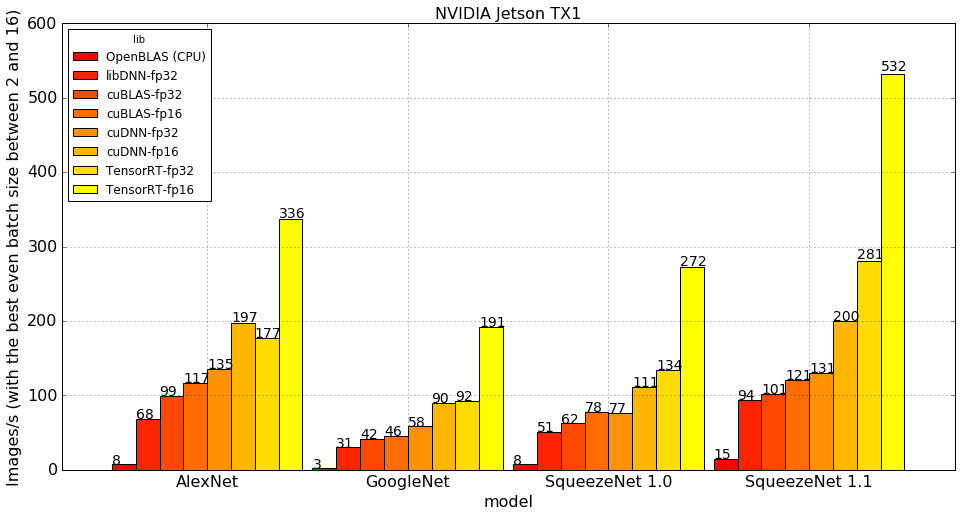

In [33]:
plot_max_num_images_per_second(df_mean_time_per_image, libs_to_drop=[], fontsize=14)

In [34]:
# What is the batch size that gives the minimum time per image (or the maximum number of images per second)?
df_mean_time_per_image.idxmin(axis=1)

model                     lib              
bvlc-alexnet              cpu                  16
                          libdnn-cuda          16
                          nvidia-cuda          16
                          nvidia-cudnn         16
                          nvidia-fp16-cuda     12
                          nvidia-fp16-cudnn    16
                          tensorrt-fp16        16
                          tensorrt-fp32        14
bvlc-googlenet            cpu                  16
                          libdnn-cuda          16
                          nvidia-cuda          16
                          nvidia-cudnn         16
                          nvidia-fp16-cuda     16
                          nvidia-fp16-cudnn    16
                          tensorrt-fp16        10
                          tensorrt-fp32        10
deepscale-squeezenet-1.0  cpu                  12
                          libdnn-cuda          14
                          nvidia-cuda          16
      

In [35]:
# Focus on e.g. nvidia-fp16-cuda, for which the batch size of 16 is not always the best.
df_mean_time_per_image.idxmin(axis=1).reorder_levels(['lib', 'model']).loc['nvidia-fp16-cuda']

model
bvlc-alexnet                12
bvlc-googlenet              16
deepscale-squeezenet-1.0    16
deepscale-squeezenet-1.1    14
dtype: int64

In [36]:
# # Is the same answer as via .min(axis=1).values?
# df_mean_time_per_image.lookup(df_mean_time_per_image.index, df_mean_time_per_image.idxmin(axis=1)) \
#     == df_mean_time_per_image.min(axis=1).values

In [37]:
df_time_per_image = df_time / (batch_sizes*(len(df_time.columns)/len(batch_sizes)))

In [38]:
df_min_time_per_image_index = pd.DataFrame(df_mean_time_per_image.idxmin(axis=1)).set_index(0, append=True).index.values

In [39]:
df_model_lib = df_time_per_image[df_min_time_per_image_index] \
    .stack(['model', 'lib']).reorder_levels(['model','lib','repetition']).sum(axis=1)

In [40]:
df_model_lib_mean = df_model_lib.groupby(level=['model', 'lib']).mean()
df_model_lib_std  = df_model_lib.groupby(level=['model', 'lib']).std()

In [41]:
zero_positive_infinity = df_model_lib_mean > 1e5
df_model_lib_mean[zero_positive_infinity] = 0

In [42]:
# exclude_positive_infinity = df_model_lib_mean < 1e6
# df_model_lib_mean = df_model_lib_mean[exclude_positive_infinity]
# df_model_lib_std = df_model_lib_std[exclude_positive_infinity]

<a id="plot_models"></a>
## Plot by Caffe models

<a id="plot_models_all"></a>
### All libs

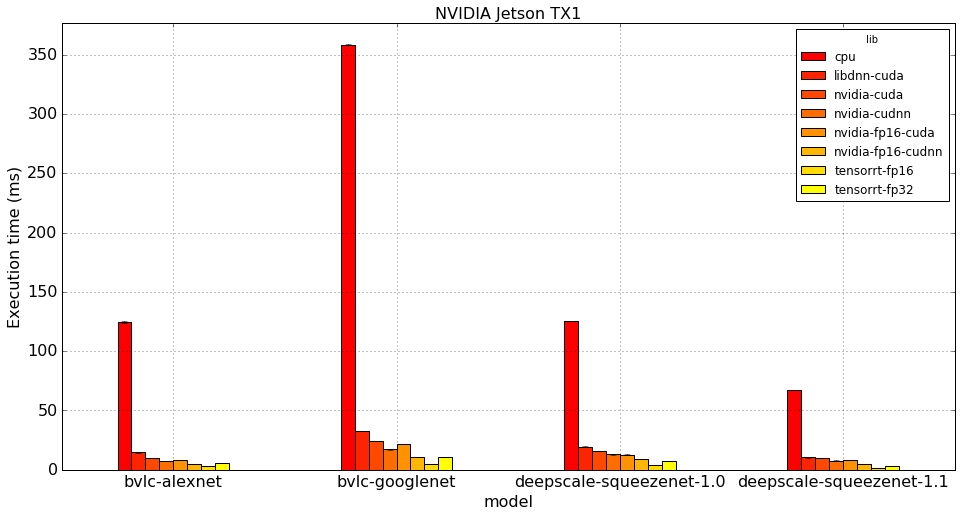

In [43]:
mean = df_model_lib_mean.unstack('lib')
std  = df_model_lib_std.unstack('lib')
plot(mean, std)

<a id="plot_models_gpu"></a>
### Only GPU libs

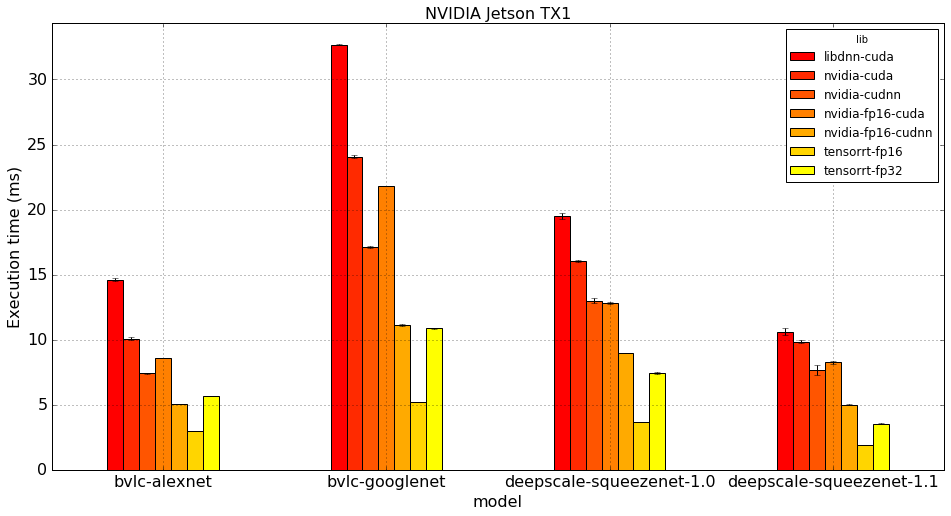

In [44]:
mean = df_model_lib_mean.unstack('lib').drop('cpu', axis=1)
std  = df_model_lib_std.unstack('lib').drop('cpu', axis=1)
plot(mean, std)

<a id="plot_models_cuda"></a>
### Only GPU libs with CUDA-level fp32 performance

In [45]:
cuda_level_performance = ['nvidia-cuda', 'nvidia-cudnn', 'libdnn-cuda']

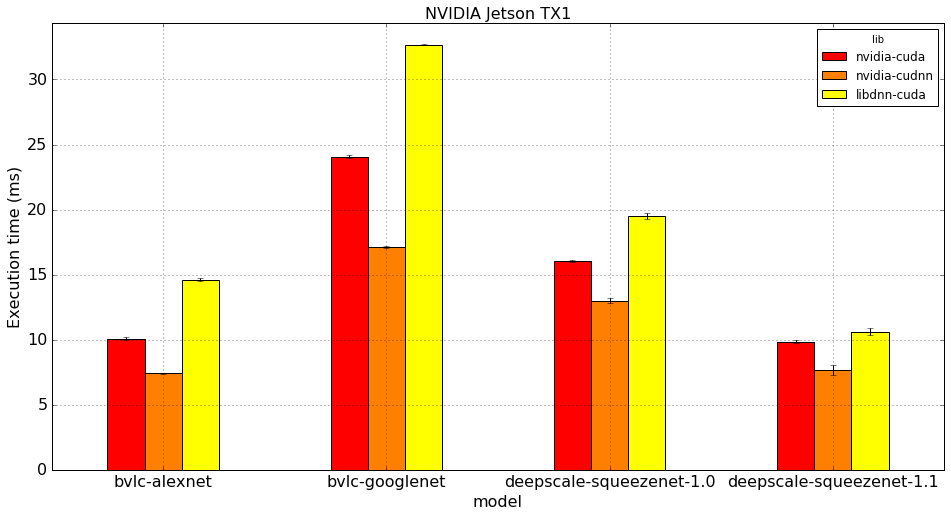

In [46]:
mean = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
std = df_model_lib_std.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
plot(mean, std)

<a id="plot_models_cublas"></a>
### Only GPU libs using cuBLAS

In [47]:
cublas_libs = ['nvidia-cuda', 'nvidia-fp16-cuda']

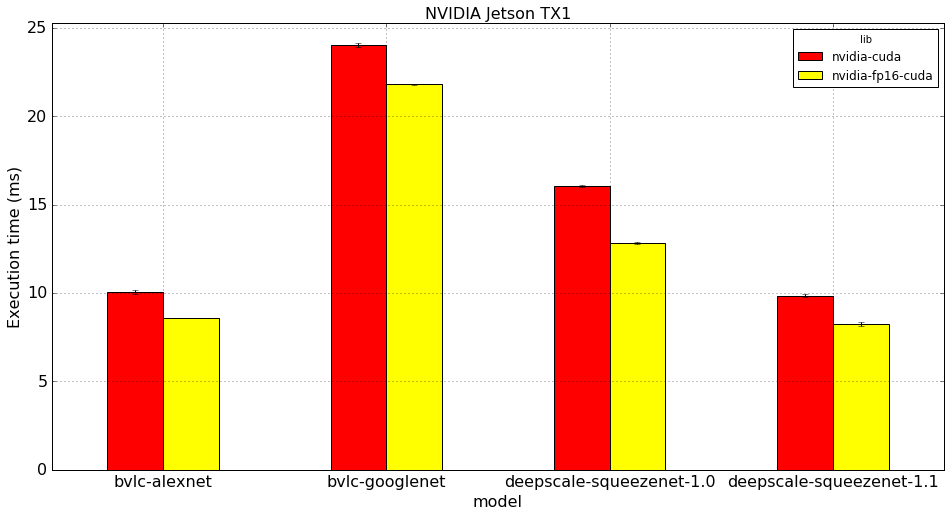

In [48]:
mean = df_model_lib_mean.reorder_levels(['lib', 'model'])[cublas_libs].unstack('lib')
std = df_model_lib_std.reorder_levels(['lib', 'model'])[cublas_libs].unstack('lib')
plot(mean, std)

In [49]:
# With cuBLAS, NVIDIA's fp16 branch is up to 20% faster than NVIDIA's fp32 mainline.
nvidia_fp16_cuda_vs_nvidia_fp32_cuda = mean['nvidia-fp16-cuda'] / mean['nvidia-cuda']
nvidia_fp16_cuda_vs_nvidia_fp32_cuda

model
bvlc-alexnet                0.851548
bvlc-googlenet              0.906930
deepscale-squeezenet-1.0    0.799011
deepscale-squeezenet-1.1    0.837633
dtype: float64

<a id="plot_models_cudnn"></a>
### Only GPU libs using cuDNN

In [50]:
cudnn_libs = ['nvidia-cudnn', 'nvidia-fp16-cudnn']

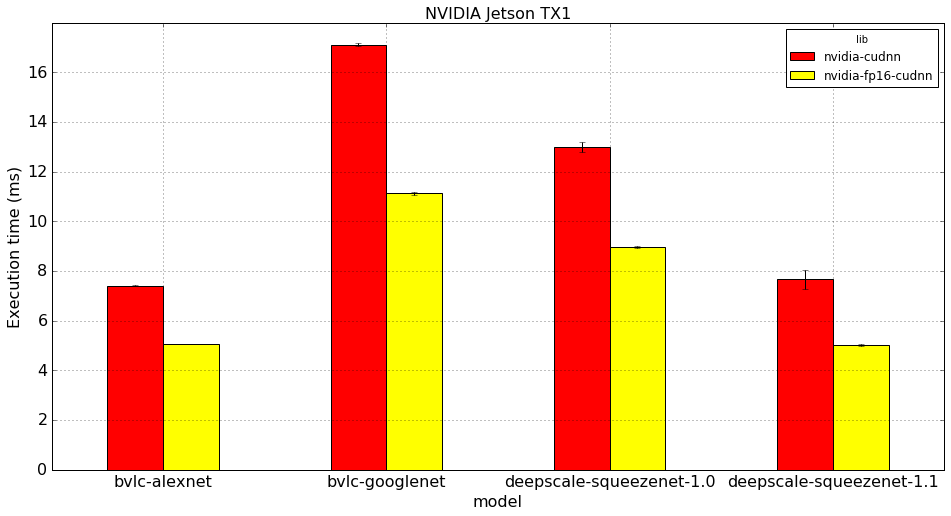

In [51]:
mean = df_model_lib_mean.reorder_levels(['lib', 'model'])[cudnn_libs].unstack('lib')
std = df_model_lib_std.reorder_levels(['lib', 'model'])[cudnn_libs].unstack('lib')
plot(mean, std)

In [52]:
# With cuDNN, NVIDIA's fp16 branch is up to 35% (roughly one third) faster than NVIDIA's fp32 mainline.
nvidia_fp16_cudnn_vs_nvidia_fp32_cudnn = mean['nvidia-fp16-cudnn'] / mean['nvidia-cudnn']
nvidia_fp16_cudnn_vs_nvidia_fp32_cudnn

model
bvlc-alexnet                0.683207
bvlc-googlenet              0.650557
deepscale-squeezenet-1.0    0.689820
deepscale-squeezenet-1.1    0.654235
dtype: float64

<a id="plot_models_tensorrt"></a>
### TensorRT vs cuDNN

In [53]:
libs = [ 'nvidia-cudnn', 'nvidia-fp16-cudnn', 'tensorrt-fp32', 'tensorrt-fp16' ]

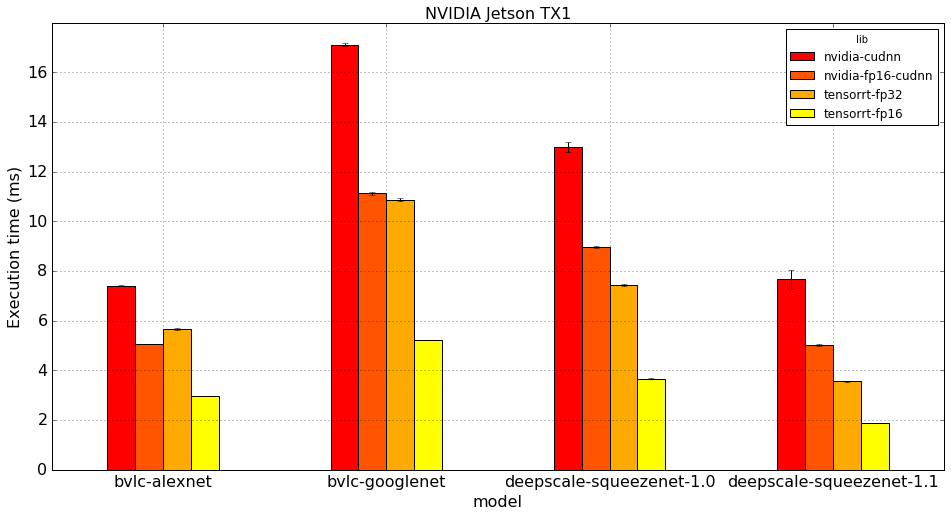

In [54]:
mean = df_model_lib_mean.reorder_levels(['lib', 'model'])[libs].unstack('lib')
std = df_model_lib_std.reorder_levels(['lib', 'model'])[libs].unstack('lib')
plot(mean, std)

In [55]:
# TensorRT using fp16 is roughly twice as fast as TensorRT using fp32.
tensorrt_fp16_vs_tensorrt_fp32 = mean['tensorrt-fp16'] / mean['tensorrt-fp32']
tensorrt_fp16_vs_tensorrt_fp32

model
bvlc-alexnet                0.524858
bvlc-googlenet              0.480515
deepscale-squeezenet-1.0    0.493366
deepscale-squeezenet-1.1    0.528403
dtype: float64

In [56]:
# TensorRT using fp32 is up to 54% faster than cuDNN using fp32.
tensorrt_fp32_vs_cudnn_fp32 = mean['tensorrt-fp32'] / mean['nvidia-cudnn']
tensorrt_fp32_vs_cudnn_fp32

model
bvlc-alexnet                0.763825
bvlc-googlenet              0.635235
deepscale-squeezenet-1.0    0.572533
deepscale-squeezenet-1.1    0.464047
dtype: float64

In [57]:
# TensorRT using fp16 is up to 63% faster than cuDNN using fp16.
tensorrt_fp16_vs_cudnn_fp16 = mean['tensorrt-fp16'] / mean['nvidia-fp16-cudnn']
tensorrt_fp16_vs_cudnn_fp16

model
bvlc-alexnet                0.586791
bvlc-googlenet              0.469198
deepscale-squeezenet-1.0    0.409481
deepscale-squeezenet-1.1    0.374795
dtype: float64

In [58]:
# TensorRT using fp16 up to 4 times faster than cuDNN using fp32.
tensorrt_fp16_vs_cudnn_fp32 = mean['tensorrt-fp16'] / mean['nvidia-cudnn']
tensorrt_fp16_vs_cudnn_fp32

model
bvlc-alexnet                0.400900
bvlc-googlenet              0.305240
deepscale-squeezenet-1.0    0.282468
deepscale-squeezenet-1.1    0.245204
dtype: float64

<a id="plot_libs"></a>
## Plot by Caffe libs

<a id="plot_libs_all"></a>
### All

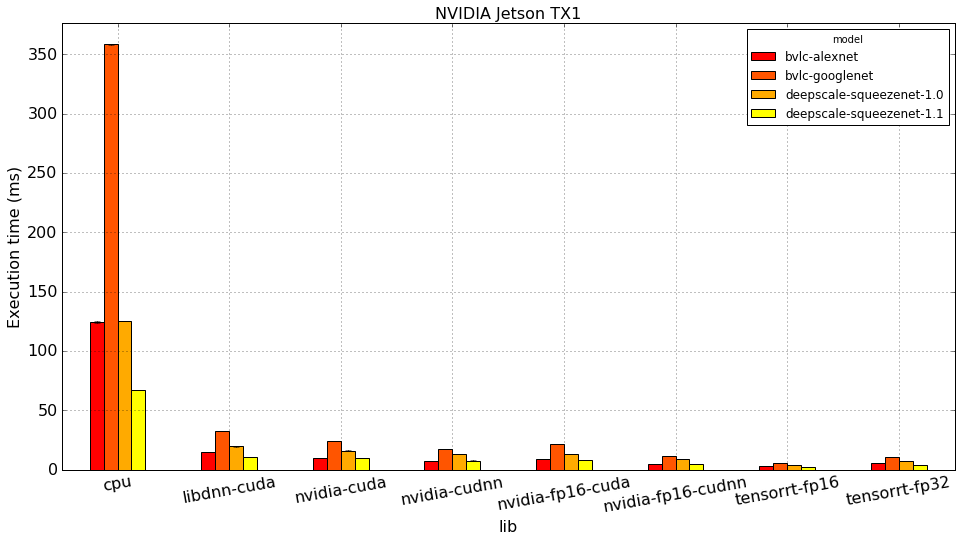

In [59]:
mean = df_model_lib_mean.unstack('model')
std  = df_model_lib_std.unstack('model')
plot(mean, std, rot=10)

<a id="plot_libs_gpu"></a>
### All models, only GPU libs

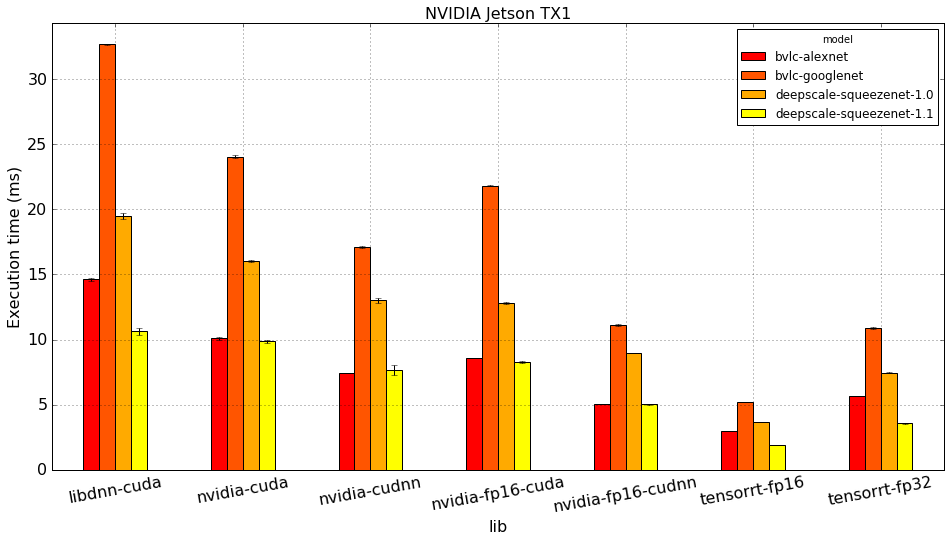

In [60]:
mean = df_model_lib_mean.unstack('model').drop('cpu', axis=0)
std  = df_model_lib_std.unstack('model').drop('cpu', axis=0)
plot(mean, std, rot=10)

<a id="plot_libs_alexnet"></a>
### Only models with AlexNet-level accuracy

In [61]:
alexnet_level_accuracy = ['bvlc-alexnet','deepscale-squeezenet-1.0','deepscale-squeezenet-1.1']

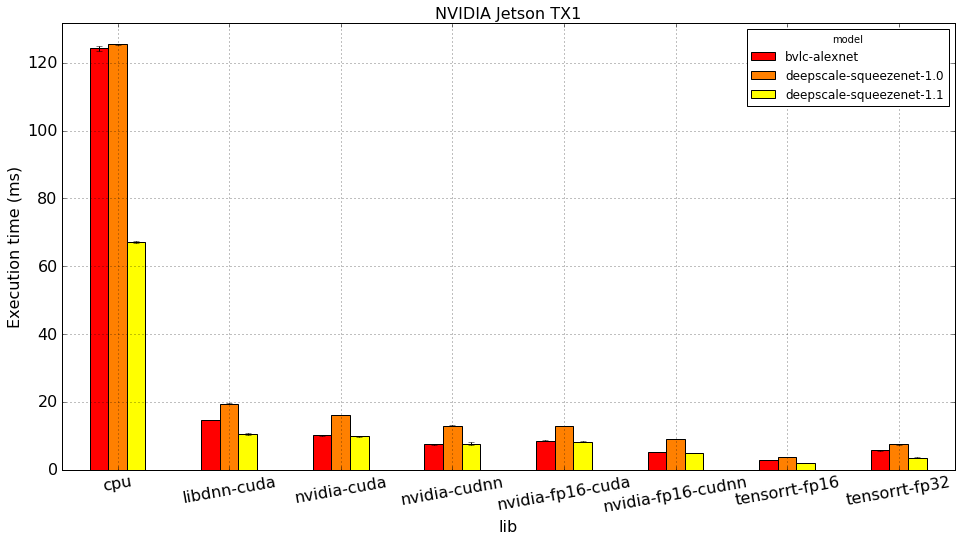

In [62]:
# On this platform with all the libraries, SqueezeNet 1.0 is always slower than AlexNet
# despite a 50x reduction in weights (5 MB vs. 250 MB).
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model')
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model')
plot(mean, std, rot=10)

<a id="plot_libs_alexnet_cpu"></a>
### Only models with AlexNet-level accuracy, only CPU lib

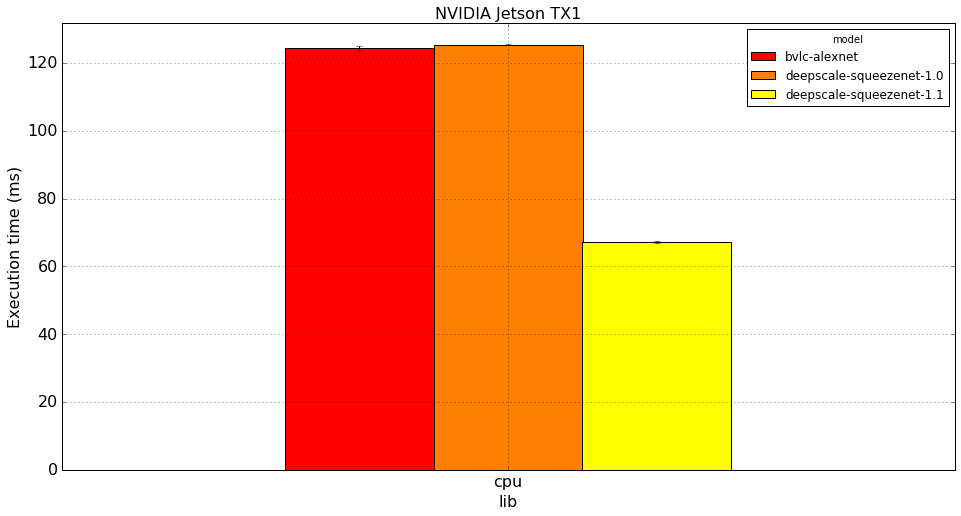

In [63]:
# SqueezeNet 1.1 is 46% faster than AlexNet with OpenBLAS (on the CPU).
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model').ix[['cpu']]
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model').ix[['cpu']]
plot(mean, std)

In [64]:
mean['deepscale-squeezenet-1.1'] / mean['bvlc-alexnet']

lib
cpu    0.540034
dtype: float64

<a id="plot_libs_alexnet_cuda"></a>
### Only models with AlexNet-level accuracy, only libs with CUDA-level performance

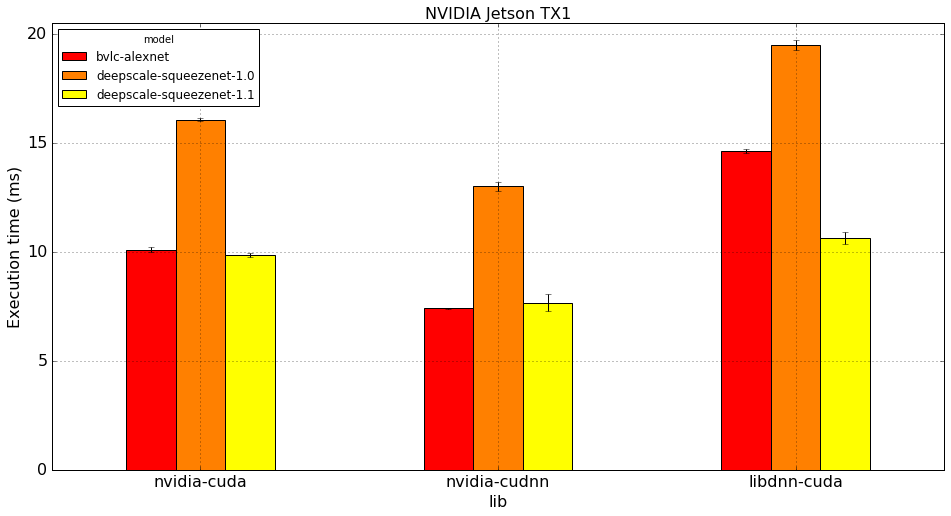

In [65]:
# SqueezeNet 1.0 is slower than AlexNet. SqueezeNet 1.1 is 28% faster than AlexNet with 
# libDNN-CUDA, and roughly equivalent to AlexNet with cuBLAS and cuDNN.
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model').ix[cuda_level_performance]
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model').ix[cuda_level_performance]
plot(mean, std)

In [66]:
mean['deepscale-squeezenet-1.1'] / mean['bvlc-alexnet']

lib
nvidia-cuda     0.977500
nvidia-cudnn    1.033459
libdnn-cuda     0.726139
dtype: float64

<a id="plot_libs_alexnet_fp16"></a>
### Only models with AlexNet-level accuracy, only fp16 libs

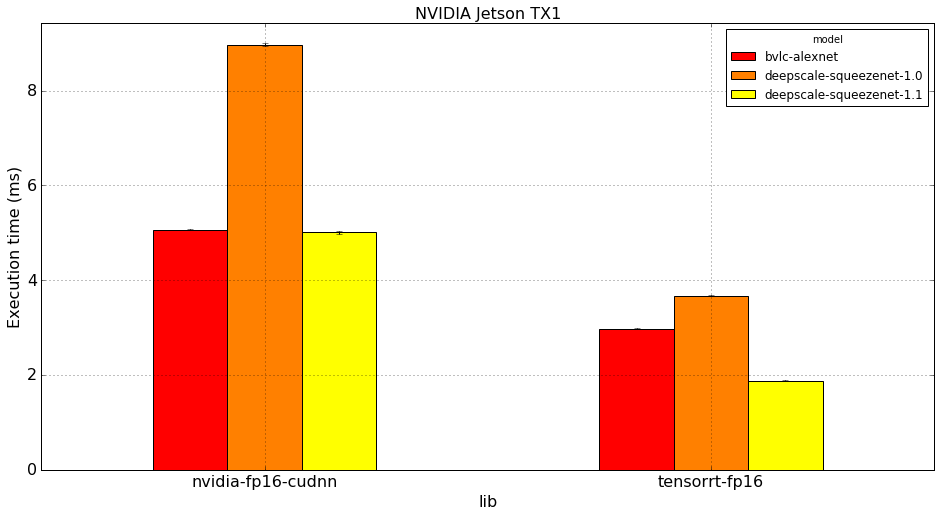

In [67]:
# SqueezeNet 1.1 achieves > 500 inferences per second with TensorRT using fp16.
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model').ix[['nvidia-fp16-cudnn', 'tensorrt-fp16']]
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model').ix[['nvidia-fp16-cudnn', 'tensorrt-fp16']]
plot(mean, std)

In [68]:
mean['deepscale-squeezenet-1.1'] / mean['bvlc-alexnet']

lib
nvidia-fp16-cudnn    0.989633
tensorrt-fp16        0.632098
dtype: float64

<a id="plot_libs_googlenet_fp16"></a>
### Only GoogleNet, only fp16 libs

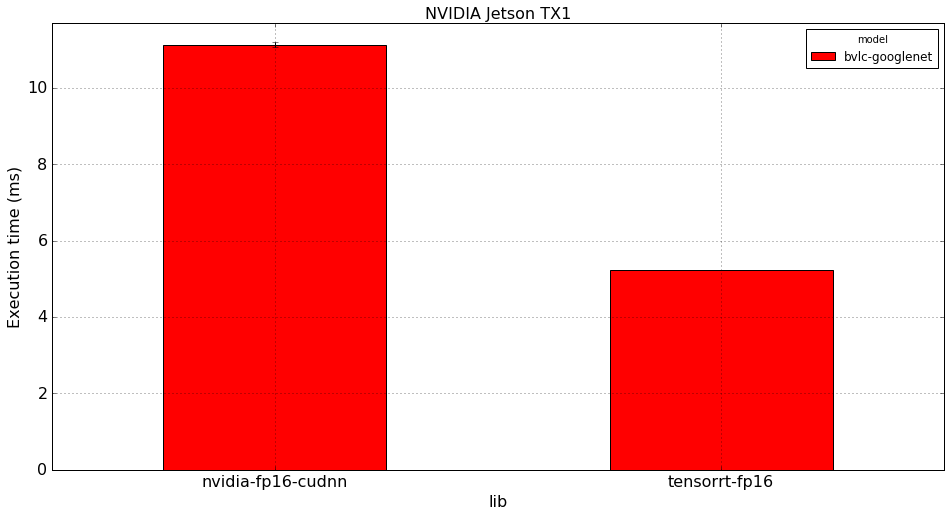

In [69]:
# GoogleNet achieves nearly 200 inferences per second with TensorRT using fp16.
mean = df_model_lib_mean[['bvlc-googlenet']].unstack('model').ix[['nvidia-fp16-cudnn', 'tensorrt-fp16']]
std  = df_model_lib_std[['bvlc-googlenet']].unstack('model').ix[['nvidia-fp16-cudnn', 'tensorrt-fp16']]
plot(mean, std)

In [70]:
# TensorRT using fp16 is more than twice as fast than cuDNN using fp16.
mean.ix['tensorrt-fp16'] / mean.ix['nvidia-fp16-cudnn']

model
bvlc-googlenet    0.469198
dtype: float64

In [71]:
images_per_second(mean['bvlc-googlenet'])

lib
nvidia-fp16-cudnn     89.840365
tensorrt-fp16        191.476509
Name: bvlc-googlenet, dtype: float64

In [72]:
# Our results (with the batch size of 16) are very close to NVIDIA's results (with the batch size of 64).
Image(url="https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/09/Figure_2-1.png")

<a id="plot_per_layer"></a>
## Plot execution time per image per layer

In [73]:
df_per_layer_info = get_per_layer_info(df_all)

In [74]:
# pd.options.display.max_columns = len(df_per_layer_info.columns)
# pd.options.display.max_rows = len(df_per_layer_info.index)
# df_per_layer_info

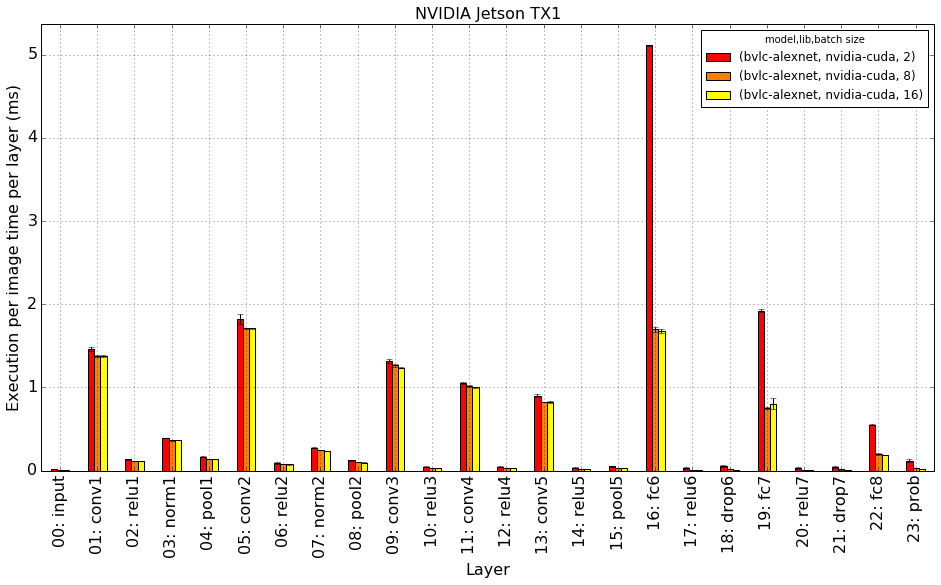

In [75]:
# Plot for a list of batch sizes.
# NB: This suggests that the fully connected layers benefit the most from larger batch sizes.
plot_time_per_image_per_layer(df_per_layer_info, model='bvlc-alexnet', libs='nvidia-cuda',
                              batch_sizes=[2, 8, 16], direction=direction)

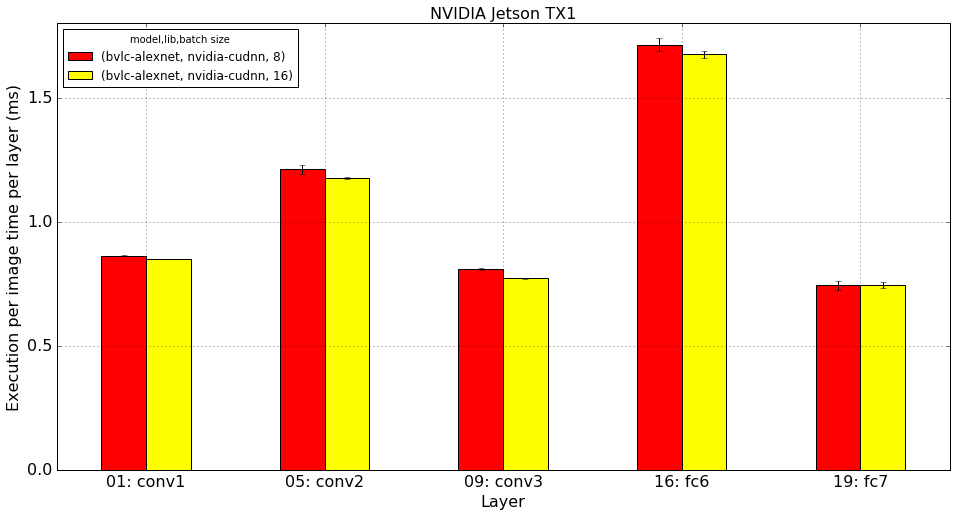

In [76]:
# Plot for a list of batch sizes. Only plot layers that consume at least 10% of the total execution time.
plot_time_per_image_per_layer(df_per_layer_info, model='bvlc-alexnet', libs='nvidia-cudnn',
                              batch_sizes=[8, 16], direction=direction, lower=0.10, rot=0)

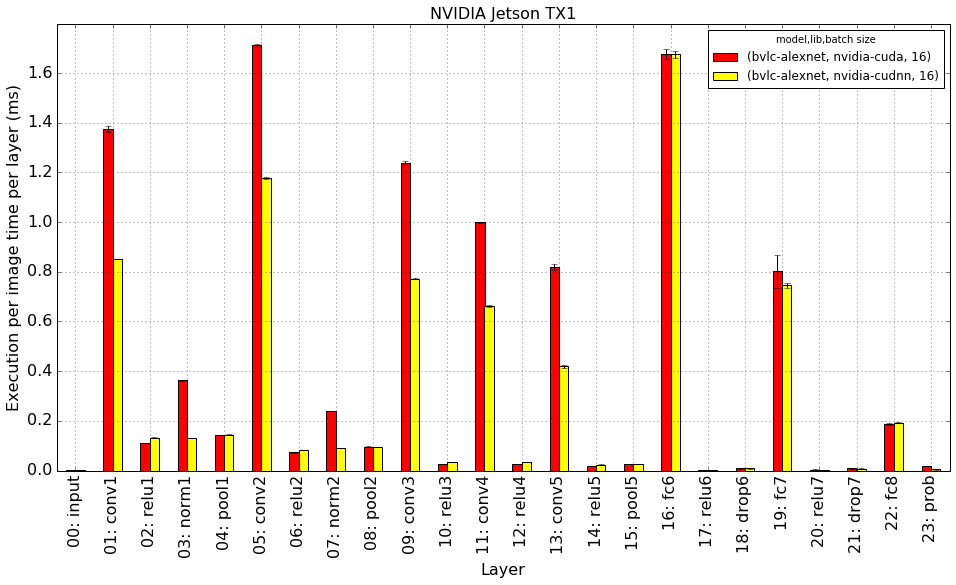

In [77]:
# Plot for a list of libs.
# NB: cuDNN and cuBLAS perform about the same on the fully connected layers (which suggests that
# cuDNN falls back to cuBLAS for these).
# Unsurprisingly, cuDNN performs better than cuBLAS on the convolution layers.
# Surprisingly, cuBLAS performs a bit better than cuDNN on the relu layers.
plot_time_per_image_per_layer(df_per_layer_info, model='bvlc-alexnet', libs=['nvidia-cuda','nvidia-cudnn'],
                              batch_sizes=16, direction=direction)

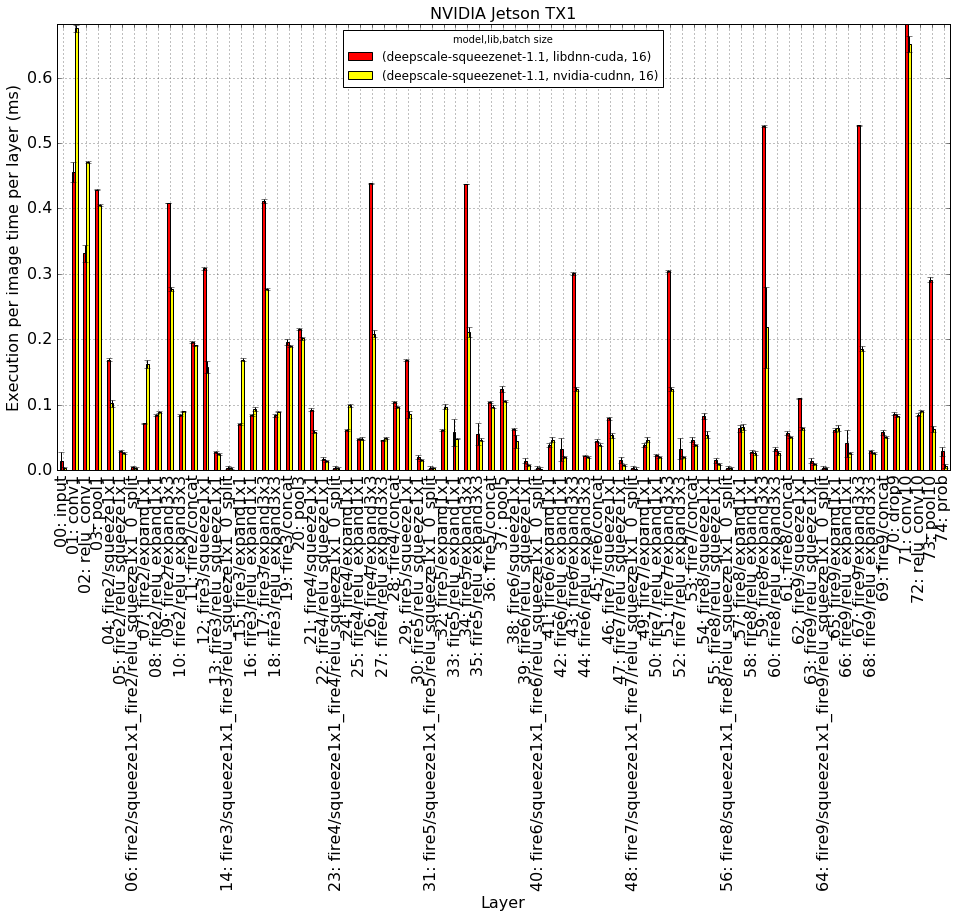

In [78]:
# Plot for a list of libs.
# NB: This suggests that libDNN is faster than cuDNN on the conv1 and expand1x1 layers, but slower on the squeeze1x1, 
# expand3x3, conv/pool10 layers. (Recall that libDNN is not yet tuned for TX1 but uses parameters optimal for GTX 1080.)
plot_time_per_image_per_layer(df_per_layer_info, model='deepscale-squeezenet-1.1', libs=['nvidia-cudnn', 'libdnn-cuda'],
                              batch_sizes=16, direction=direction, ymax=0.65)

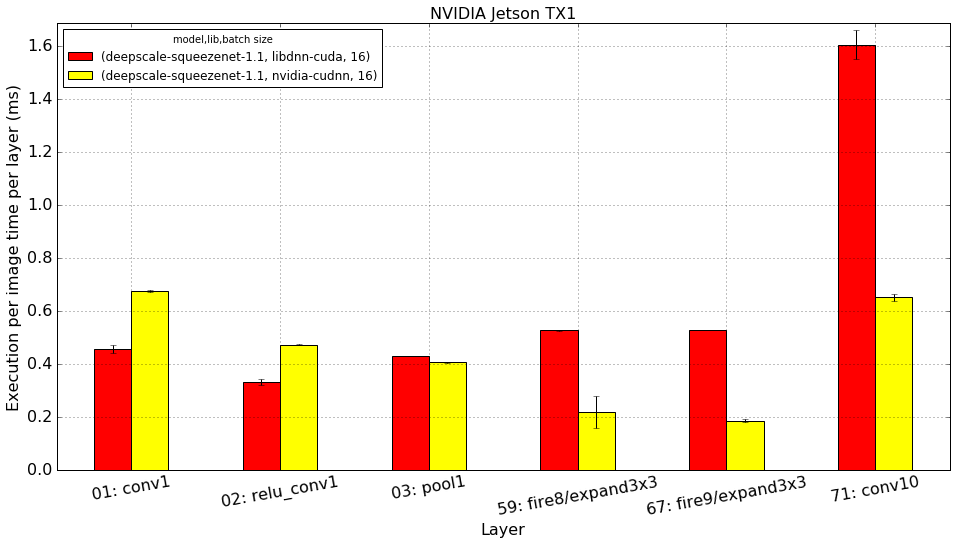

In [79]:
# Plot for a list of libs. Only plot layers that consume between 5% and 10% of the total execution time.
# NB: libDNN is slower than cuDNN on the expand3x3 layers and conv10 layers, but a bit faster on the conv1 layer.
plot_time_per_image_per_layer(df_per_layer_info, model='deepscale-squeezenet-1.1', libs=['nvidia-cudnn', 'libdnn-cuda'],
                              batch_sizes=16, direction=direction, lower=0.05, upper=0.10, rot=10)

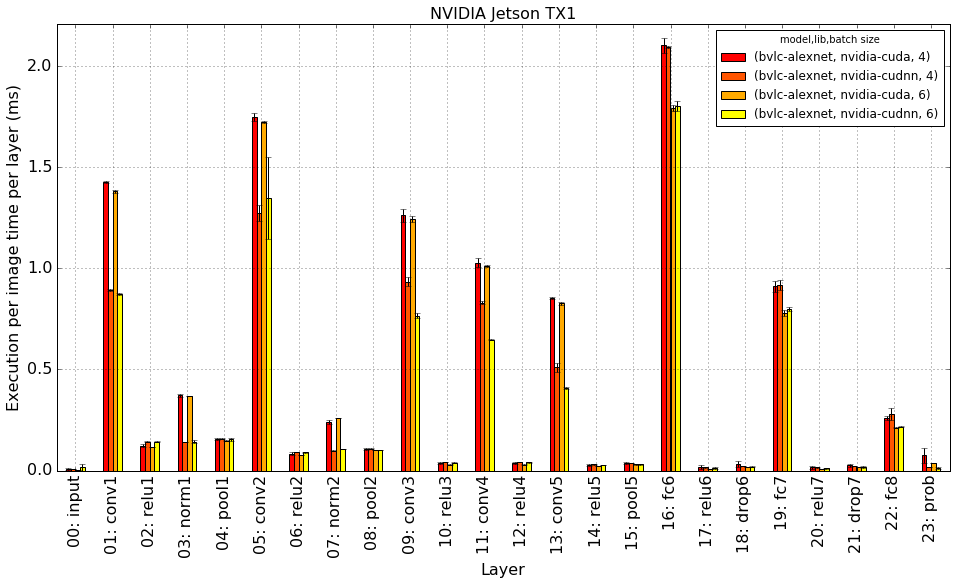

In [80]:
# Plot for a list of libs and a list of batch sizes. (This works but might not be terribly legible).
plot_time_per_image_per_layer(df_per_layer_info, model='bvlc-alexnet', libs=['nvidia-cudnn', 'nvidia-cuda'],
                              batch_sizes=[4,6], direction=direction)

<a id="plot_ideal"></a>
## Plot the ideal adaptive solution

Overall, using cuDNN typically results in the minimum execution time. For some layers, however, other libraries may outperform cuDNN (e.g. libDNN from the OpenCL branch of Caffe). As we show below, using the best performing library per layer results in up to 17% execution time reduction over using cuDNN alone. For other models and on other platforms such adaptation can potentially results even in higher savings (e.g. up to 22% on the GTX 1080).

**NB:** Currently, the savings are hypothetical. However, Caffe allows for manual adaptation, i.e. the user can specify the engine to use for each layer in the model file (`*.prototxt`). We are working on generating the optimized model file automatically from the obtained ideal adaptive solution. Please [contact us](info@dividiti.com) if you are interested.

<a id="plot_ideal_all"></a>
### Using all reasonable libs for adaptation

In [81]:
all_libs = df_per_layer_info.index.get_level_values('lib').drop_duplicates() \
    .drop(['nvidia-fp16-cuda', 'nvidia-fp16-cudnn', 'tensorrt-fp16', 'tensorrt-fp32'])
all_libs

Index([u'cpu', u'libdnn-cuda', u'nvidia-cuda', u'nvidia-cudnn'], dtype='object', name=u'lib')

Each row specifies an ideal adaptive solution for a model. Each column specifies the execution time (in ms per image) that the ideal adaptive solution would cumulatively spend using a particular library.

In [82]:
df_ideal_all = get_ideal_adaptive_solution(df_per_layer_info, all_libs, direction)
df_ideal_all

lib,cpu,libdnn-cuda,nvidia-cuda,nvidia-cudnn
model,,,,
deepscale-squeezenet-1.1,0.002339,0.825522,2.406508,3.063189
bvlc-alexnet,0.000500,1.656031,0.616434,4.804996
deepscale-squeezenet-1.0,0.002098,0.861213,3.959106,6.824531
bvlc-googlenet,0.003723,0.166052,4.076741,11.693360


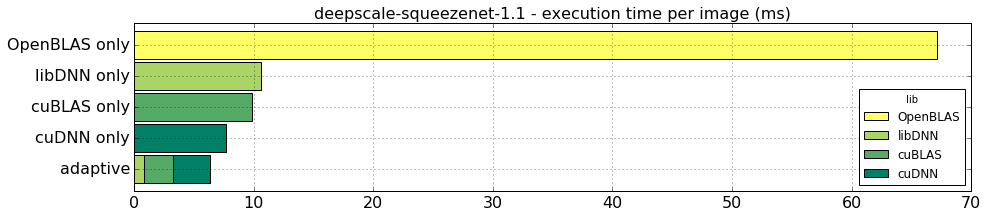

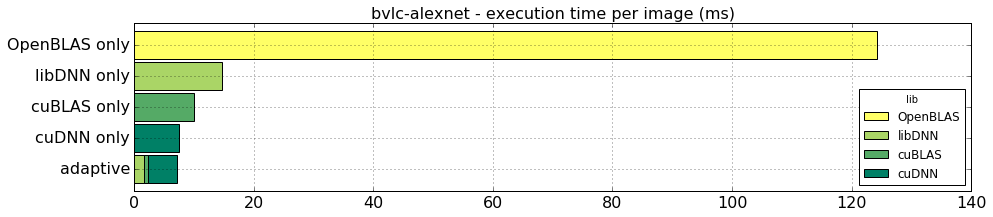

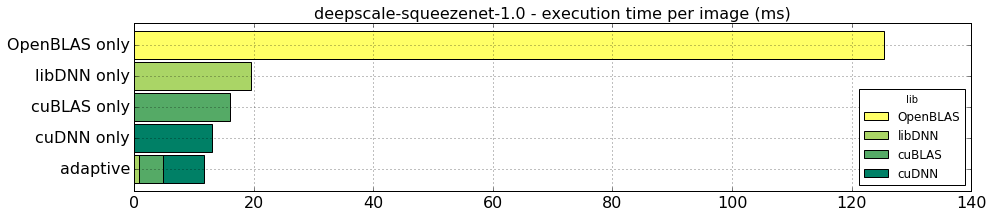

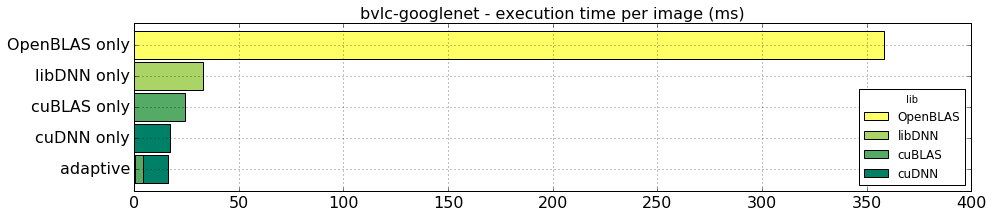

In [83]:
plot_ideal_adaptive_solution(df_ideal_all, df_model_lib_mean)

In [84]:
# Up to 17% execution time reduction compared to the best non-adaptive solution (i.e. cuDNN).
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
df_ideal_all.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.954758
bvlc-googlenet              0.931626
deepscale-squeezenet-1.0    0.895721
deepscale-squeezenet-1.1    0.821986
dtype: float64

<a id="plot_ideal_cuda"></a>
### Using CUDA-level performance libs for adaptation

In [85]:
df_ideal_cuda = get_ideal_adaptive_solution(df_per_layer_info, cuda_level_performance, direction)
df_ideal_cuda

lib,nvidia-cuda,nvidia-cudnn,libdnn-cuda
model,,,
deepscale-squeezenet-1.1,2.414011,3.066857,0.825522
bvlc-alexnet,0.616434,4.806335,1.656031
deepscale-squeezenet-1.0,3.962985,6.830830,0.861213
bvlc-googlenet,4.077942,11.704643,0.166052


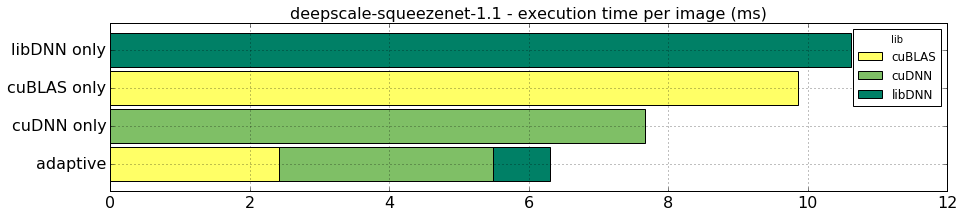

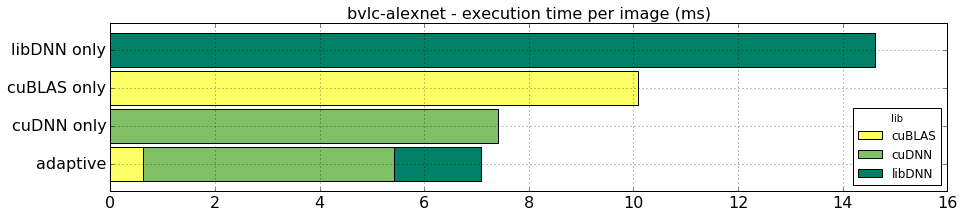

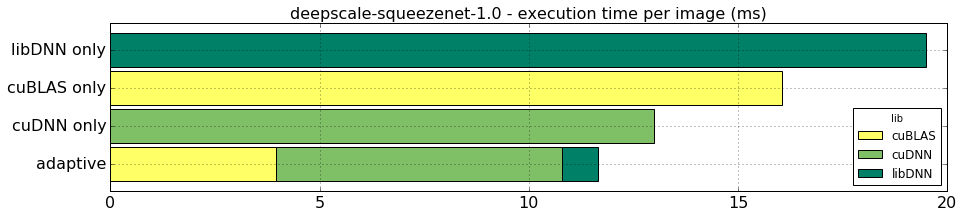

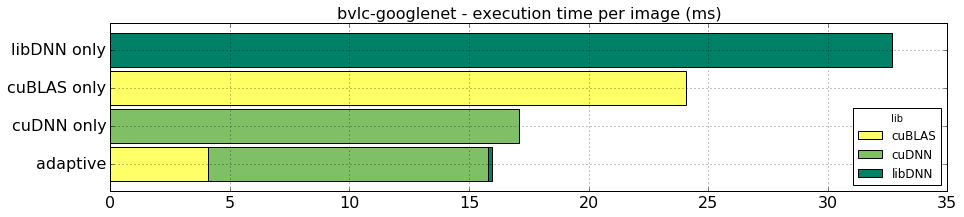

In [86]:
plot_ideal_adaptive_solution(df_ideal_cuda, df_model_lib_mean)

In [87]:
# Hypothetical execution time reduction compared to the best non-adaptive solution (i.e. cuDNN).
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
df_ideal_cuda.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.954871
bvlc-googlenet              0.932139
deepscale-squeezenet-1.0    0.896342
deepscale-squeezenet-1.1    0.823139
dtype: float64

In [88]:
# Up to 0.1% worse performance when using the CUDA-level performance libs only.
df_ideal_cuda.sum(axis=1) / df_ideal_all.sum(axis=1)

model
deepscale-squeezenet-1.1    1.001402
bvlc-alexnet                1.000119
deepscale-squeezenet-1.0    1.000694
bvlc-googlenet              1.000550
dtype: float64

<a id="plot_ideal_cudnn_cublas"></a>
### Using cuDNN and cuBLAS for adaptation

In [89]:
df_ideal_cudnn_cublas = get_ideal_adaptive_solution(df_per_layer_info, ['nvidia-cudnn', 'nvidia-cuda'], direction)
df_ideal_cudnn_cublas

lib,nvidia-cudnn,nvidia-cuda
model,,
deepscale-squeezenet-1.1,4.323794,2.474317
bvlc-alexnet,6.469998,0.616434
deepscale-squeezenet-1.0,8.072759,3.962985
bvlc-googlenet,11.917162,4.077942


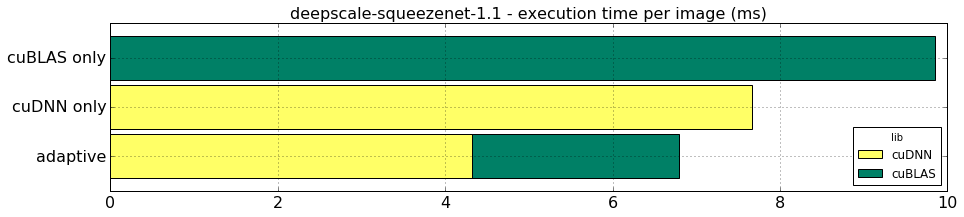

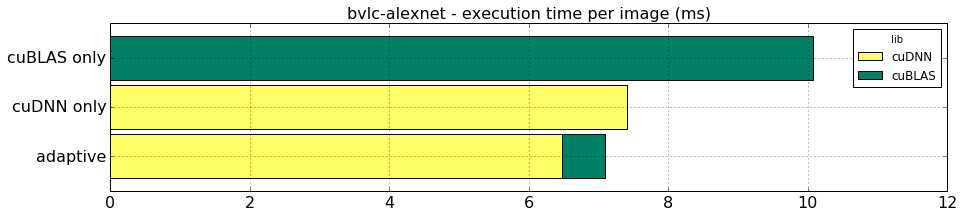

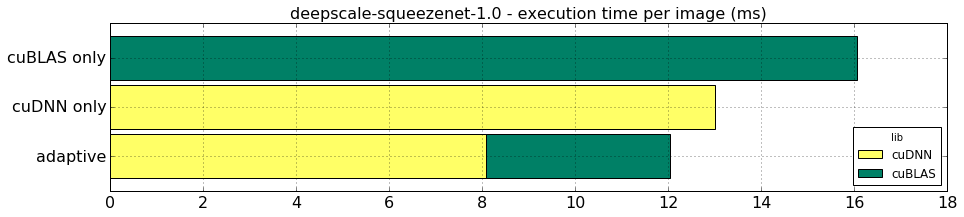

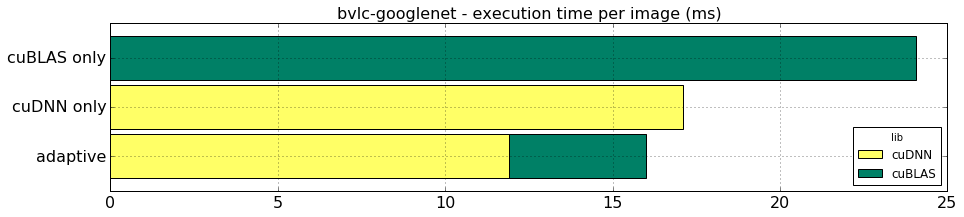

In [90]:
plot_ideal_adaptive_solution(df_ideal_cudnn_cublas, df_model_lib_mean)

In [91]:
# Hypothetical execution time reduction compared to the best non-adaptive solution (i.e. cuDNN).
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
df_ideal_cudnn_cublas.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.955901
bvlc-googlenet              0.934854
deepscale-squeezenet-1.0    0.925622
deepscale-squeezenet-1.1    0.887320
dtype: float64

In [92]:
# Up to 8% worse performance when using cuDNN+cuBLAS only.
df_ideal_cudnn_cublas.sum(axis=1) / df_ideal_all.sum(axis=1)

model
deepscale-squeezenet-1.1    1.079484
bvlc-alexnet                1.001197
deepscale-squeezenet-1.0    1.033382
bvlc-googlenet              1.003465
dtype: float64

<a id="plot_ideal_cudnn_libdnn"></a>
### Using cuDNN and libDNN for adaptation

In [93]:
df_ideal_cudnn_libdnn = get_ideal_adaptive_solution(df_per_layer_info, ['nvidia-cudnn', 'libdnn-cuda'], direction)
df_ideal_cudnn_libdnn

lib,nvidia-cudnn,libdnn-cuda
model,,
deepscale-squeezenet-1.1,4.672342,1.735223
bvlc-alexnet,5.180496,1.925741
deepscale-squeezenet-1.0,9.148563,2.605430
bvlc-googlenet,14.880228,1.208790


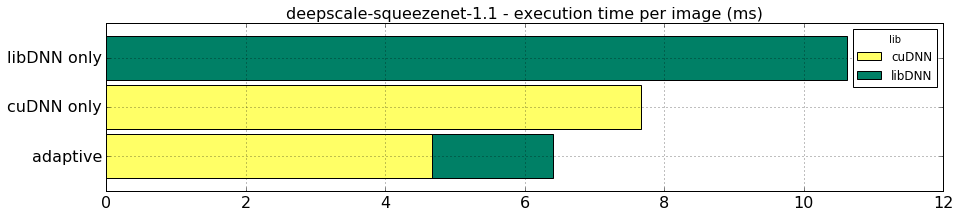

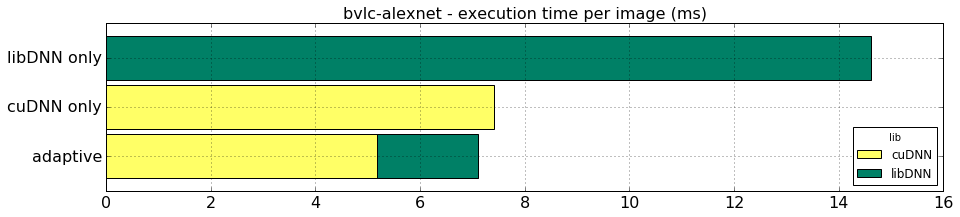

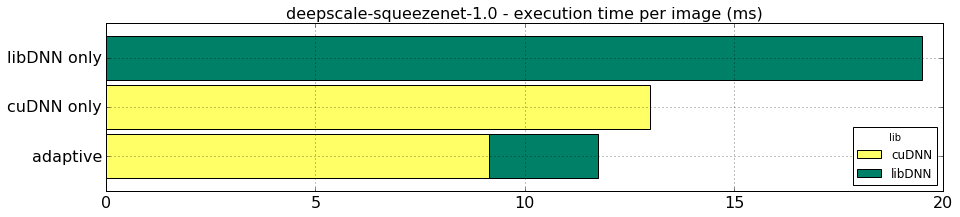

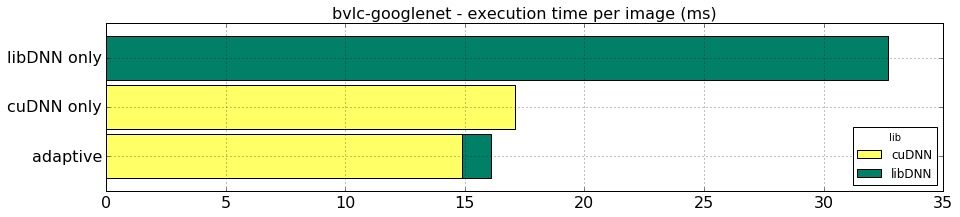

In [94]:
plot_ideal_adaptive_solution(df_ideal_cudnn_libdnn, df_model_lib_mean)

In [95]:
# Hypothetical execution time reduction compared to the best non-adaptive solution (i.e. cuDNN).
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model'])[cuda_level_performance].unstack('lib')
df_ideal_cudnn_libdnn.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.958573
bvlc-googlenet              0.940343
deepscale-squeezenet-1.0    0.903953
deepscale-squeezenet-1.1    0.836344
dtype: float64

In [96]:
# Less than 2% worse performance when using cuDNN+libDNN only.
df_ideal_cudnn_libdnn.sum(axis=1) / df_ideal_all.sum(axis=1)

model
deepscale-squeezenet-1.1    1.017468
bvlc-alexnet                1.003995
deepscale-squeezenet-1.0    1.009191
bvlc-googlenet              1.009356
dtype: float64

<a id="plot_memory"></a>
## Plot memory consumption

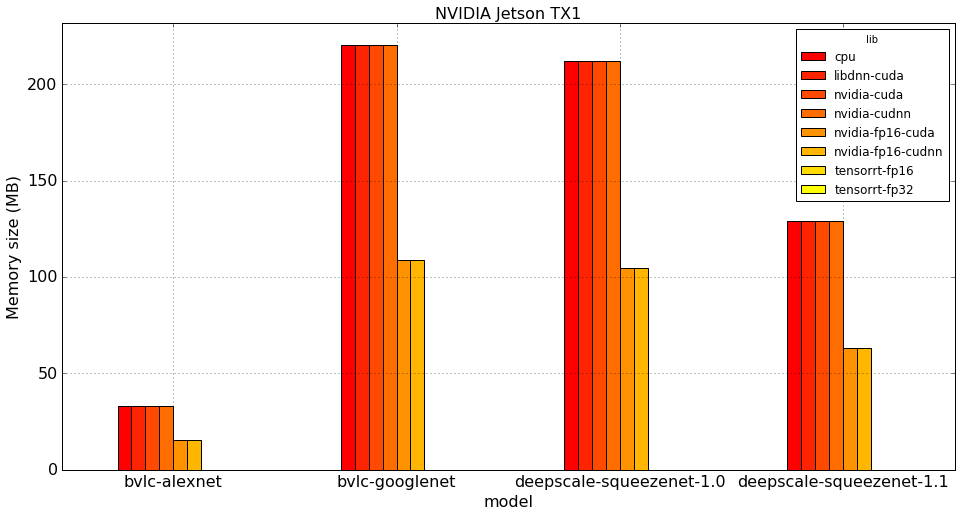

In [97]:
df_memory = df_all['memory (MB)']
# Batch size of 4; repetition 0 (should always be available).
df_memory = df_memory.unstack(['model','lib']).loc[4].loc[0].unstack('lib')
plot(mean=df_memory, std=pd.DataFrame(), ylabel='Memory size (MB)')

<a id="balance_memory_time"></a>
### Balance memory consumption and execution time per image

The above, however, does not tell the full story. The memory consumption, as reported by Caffe, increases linearly with the batch size. In other words, the memory consumption per image is constant. (Note that extra memory may be required e.g. for GPU buffers in host memory.)

The execution time per image, however, decreases asymptotically. Since minimizing the execution time almost always should be balanced with minimizing the memory consumption, we should select the batch size that results in "good enough" performance.

We give several examples below. Note that the execution time per batch is omitted to make the execution time per image more pronounced.

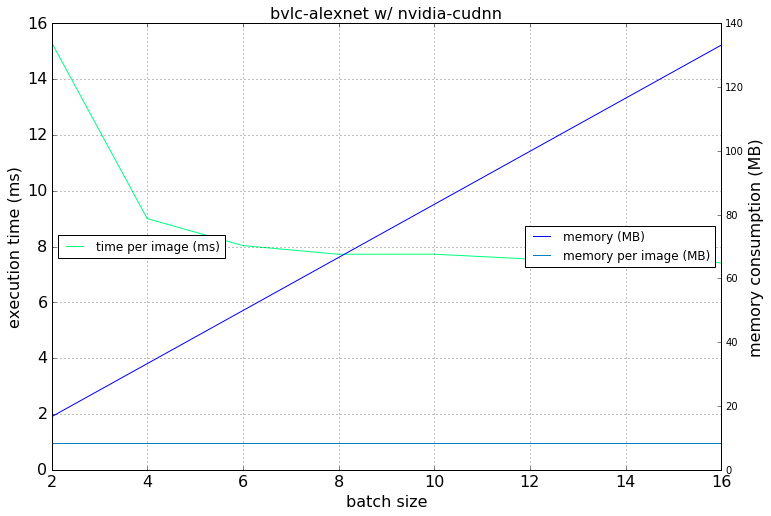

In [98]:
# Is the batch size of 8 "good enough"?
plot_time_per_image_and_memory_consumption(df_all, 'bvlc-alexnet', 'nvidia-cudnn')

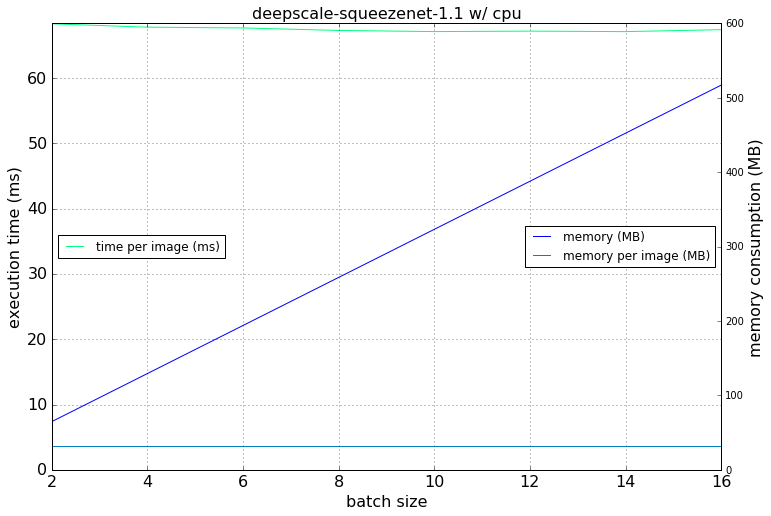

In [99]:
# Is the batch size of 2 "good enough"?
plot_time_per_image_and_memory_consumption(df_all, 'deepscale-squeezenet-1.1', 'cpu')

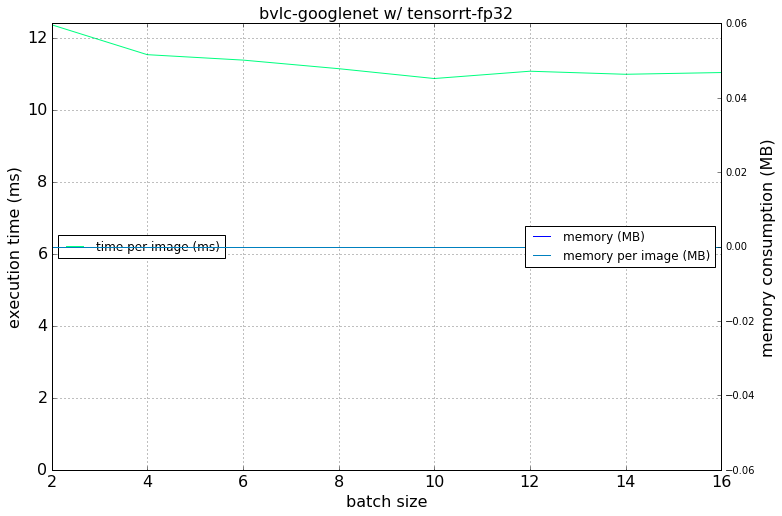

In [100]:
# Is the batch size of 10 "good enough"?
plot_time_per_image_and_memory_consumption(df_all, 'bvlc-googlenet', 'tensorrt-fp32')

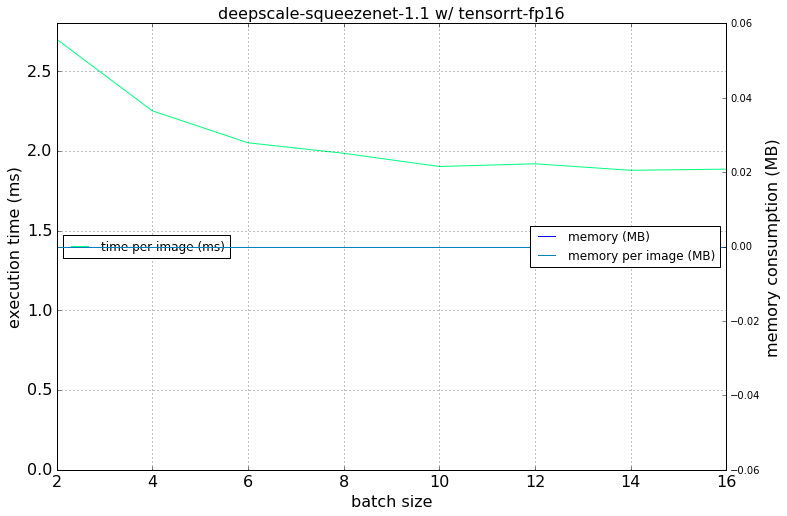

In [101]:
# Is the batch size of 8 "good enough" (below 2 ms per image)?
plot_time_per_image_and_memory_consumption(df_all, 'deepscale-squeezenet-1.1', 'tensorrt-fp16')

<a id="alexnet_vs_squeezenet"></a>
## Compare AlexNet and SqueezeNet 1.1

<a id="alexnet_vs_squeezenet_memory"></a>
### Memory consumption

In [102]:
# SqueezeNet consumes about 4 times more memory than AlexNet.
df_memory.ix[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].iloc[1] / \
df_memory.ix[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].iloc[0]

lib
cpu                  3.882476
libdnn-cuda          3.882476
nvidia-cuda          3.882476
nvidia-cudnn         3.882476
nvidia-fp16-cuda     4.113806
nvidia-fp16-cudnn    4.113806
tensorrt-fp16             NaN
tensorrt-fp32             NaN
dtype: float64

<a id="alexnet_vs_squeezenet_time"></a>
### Execution time

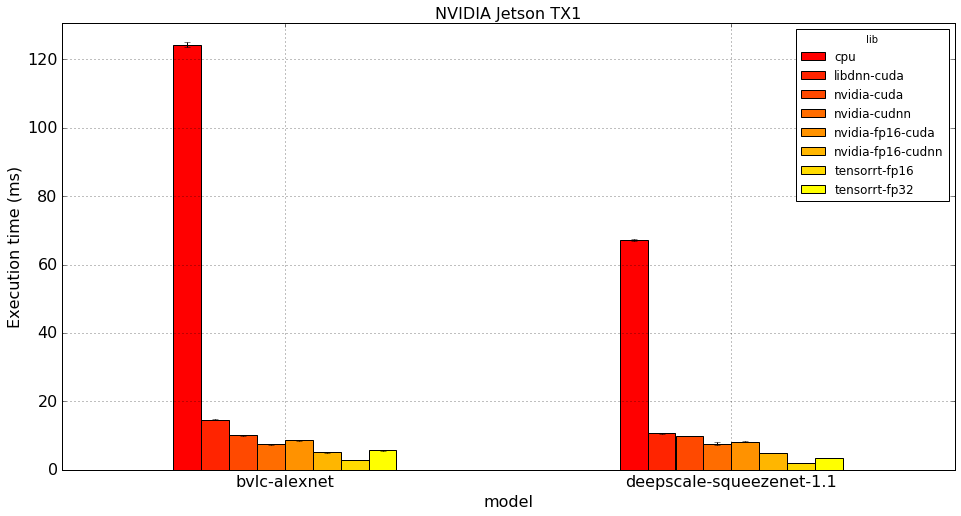

In [103]:
# Using TensorRT, SqueezeNet is over 1.5 times faster than AlexNet.
mean = df_model_lib_mean[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib')
std  = df_model_lib_std[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib')
plot(mean, std)

In [104]:
# Using TensorRT, SqueezeNet is over 1.5 times faster than AlexNet.
df_model_lib_mean[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib').iloc[1] / \
df_model_lib_mean[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib').iloc[0]

lib
cpu                  0.540034
libdnn-cuda          0.726139
nvidia-cuda          0.977500
nvidia-cudnn         1.033459
nvidia-fp16-cuda     0.961526
nvidia-fp16-cudnn    0.989633
tensorrt-fp16        0.632098
tensorrt-fp32        0.627858
dtype: float64

<a id="conclusion"></a>
## Conclusion

<a id="improvements_of_each_approach"></a>
### What are the improvements brought on by each approach?

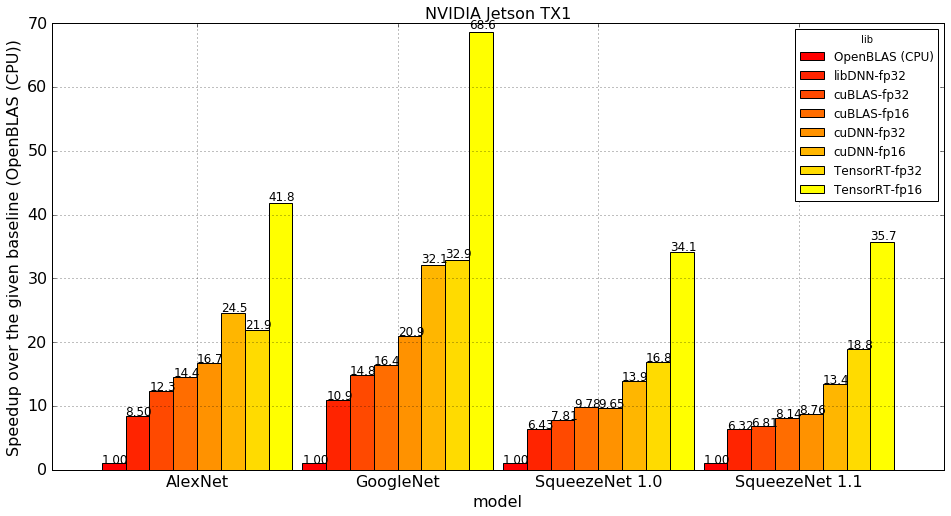

In [105]:
# TensorRT-fp16 is up to 69x faster than the CPU.
plot_speedup_over_baseline(df_mean_time_per_image, baseline='cpu', libs_to_drop=[], fontsize=12)

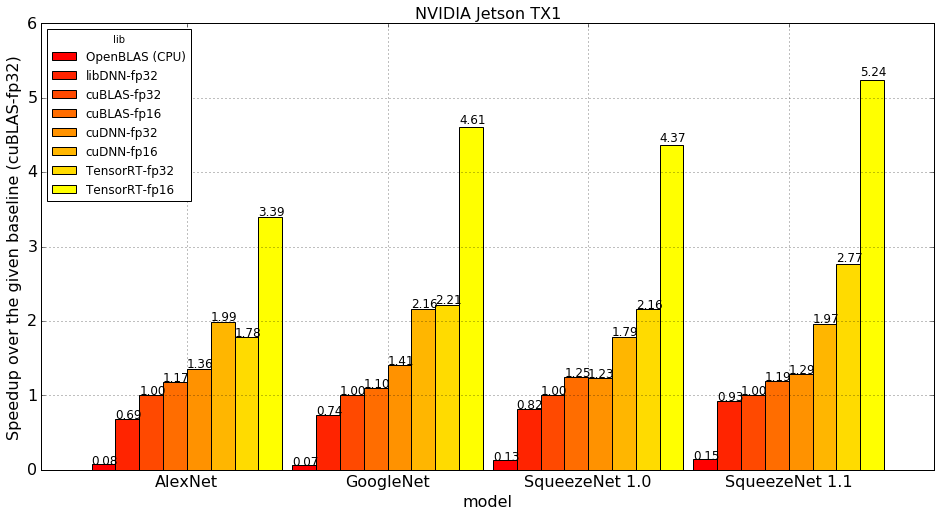

In [106]:
# cuDNN-fp16 is about 2x faster than cuBLAS-fp32. TensorRT-fp16 is up to 5.2x faster than cuBLAS-fp32.
plot_speedup_over_baseline(df_mean_time_per_image, baseline='nvidia-cuda', libs_to_drop=[], fontsize=12)

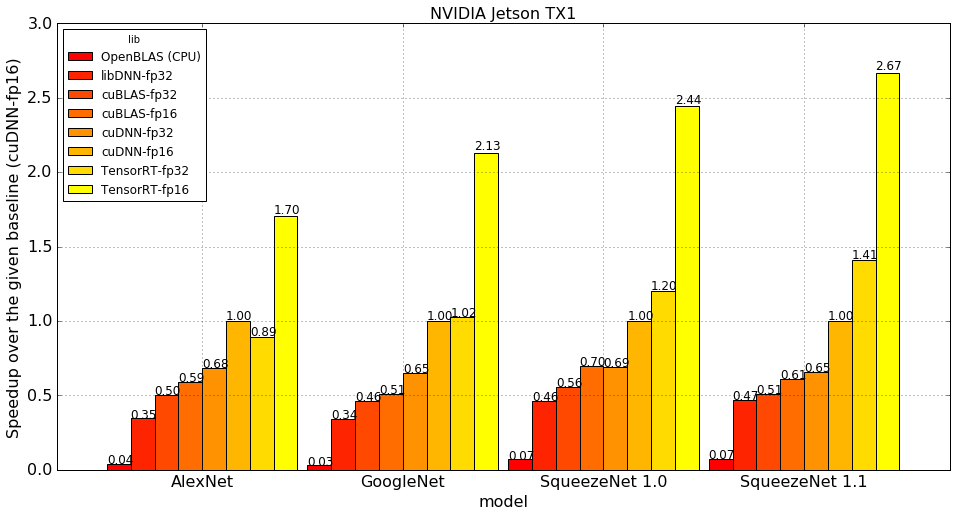

In [107]:
# TensorRT-fp16 is up to 2.7x faster than cuDNN-fp16.
plot_speedup_over_baseline(df_mean_time_per_image, baseline='nvidia-fp16-cudnn', libs_to_drop=[], fontsize=12)

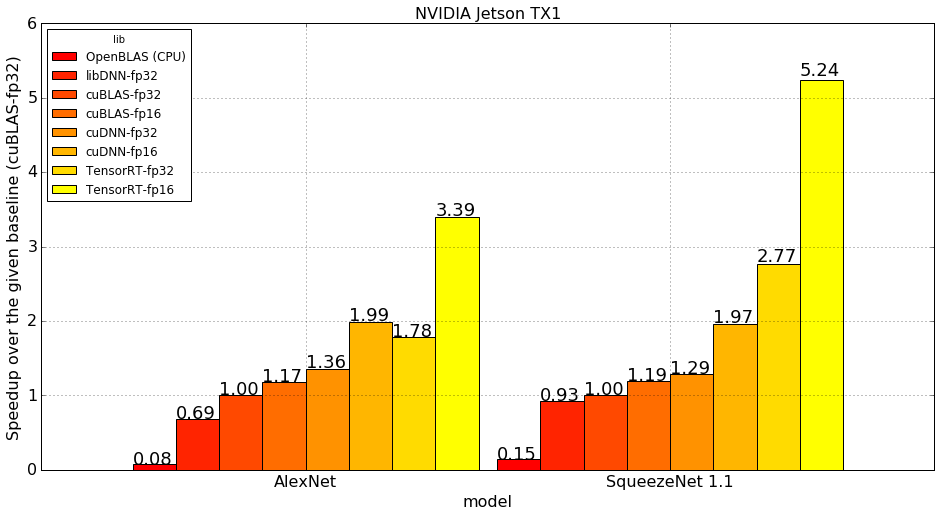

In [108]:
# AlexNet and SqueezeNet 1.1 have very similar performance with cuBLAS and cuDNN. (They also have very similar accuracy!)
# SqueezeNet, however, benefits much more from TensorRT optimizations, becoming over 1.5 times faster than AlexNet.
# At the same time, SqueezeNet requires about 4 times more memory than AlexNet (at least, with Caffe), so it's a trade-off.
plot_speedup_over_baseline(df_mean_time_per_image.ix[['bvlc-alexnet', 'deepscale-squeezenet-1.1']],
                           baseline='nvidia-cuda', libs_to_drop=[], fontsize=18)

<a id="compare_with_whitepaper"></a>
### How do dividiti's results compare with NVIDIA's results in the whitepaper?

In Nov/2015, NVIDIA published a [whitepaper](https://www.nvidia.com/content/tegra/embedded-systems/pdf/jetson_tx1_whitepaper.pdf) entitled "GPU-Based Deep Learning Inference: A Performance and Power Analysis", which presented the throughput of inference (images per second) on AlexNet and GoogleNet using small and large batch sizes.

Several points of difference complicate direct comparison:
- TX1 board support package: NVIDIA's is before Nov/2015; dividiti's is Nov/2016. [In a [pinned post](https://devtalk.nvidia.com/default/topic/935300/jetson-tx1/deep-learning-inference-performance-validation-on-tx1/) on NVIDIA's Jetson forum published in May/2016, the following are mentioned: Linux for Tegra 23.1 (vs 24.2.1); CUDA Toolkit 7.0.73 (vs 8.0.33); cuDNN 4 (vs 5.1).]
- Caffe source: NVIDIA's is probably a mix of open-source and proprietary, before Nov/2015; dividiti's is public, Nov/2016;
- "small batch size": NVIDIA's is 1; dividiti's is 2;
- "large batch size": NVIDIA's is 128 (AlexNet) and 64 (GoogleNet); dividiti's is 16;
- GPU clock frequency: NVIDIA's is 690 MHz (presumably to demonstrate better power consumption); dividiti's is 998 MHz (to demonstrate maximum performance).

In [109]:
nvidia_data = []
nvidia_data.append({
    'source':'nvidia', 'model':'bvlc-alexnet', 'batch size':1, 'clock':'690 MHz',
    'fp32 (images/s)':47, 'fp16 (images/s)':67
})
nvidia_data.append({
    'source':'nvidia', 'model':'bvlc-alexnet', 'batch size':128, 'clock':'690 MHz',
    'fp32 (images/s)':155, 'fp16 (images/s)':258 
})
nvidia_data.append({
    'source':'nvidia', 'model':'bvlc-googlenet', 'batch size':1, 'clock':'690 MHz',
    'fp32 (images/s)':33, 'fp16 (images/s)':33
})
nvidia_data.append({       
    'source':'nvidia', 'model':'bvlc-googlenet', 'batch size':64, 'clock':'690 MHz',
    'fp32 (images/s)':52, 'fp16 (images/s)':75
})

In [110]:
dividiti_data = []
dividiti_data.append({
    'source':'dividiti', 'model':'bvlc-alexnet', 'batch size':2, 'clock':'998 MHz',
    'fp32 (images/s)':(1000/(df_time['bvlc-alexnet','nvidia-cudnn',2].mean()/2)),
    'fp16 (images/s)':(1000/(df_time['bvlc-alexnet','nvidia-fp16-cudnn',2].mean()/2)),
})
dividiti_data.append({
    'source':'dividiti', 'model':'bvlc-alexnet', 'batch size':16, 'clock':'998 MHz',
    'fp32 (images/s)':(1000/(df_time['bvlc-alexnet','nvidia-cudnn',16].mean()/16)),
    'fp16 (images/s)':(1000/(df_time['bvlc-alexnet','nvidia-fp16-cudnn',16].mean()/16)),
})
dividiti_data.append({
    'source':'dividiti', 'model':'bvlc-googlenet', 'batch size':2, 'clock':'998 MHz',
    'fp32 (images/s)':(1000/(df_time['bvlc-googlenet','nvidia-cudnn',2].mean()/2)),
    'fp16 (images/s)':(1000/(df_time['bvlc-googlenet','nvidia-fp16-cudnn',2].mean()/2)),
})
dividiti_data.append({
    'source':'dividiti', 'model':'bvlc-googlenet', 'batch size':16, 'clock':'998 MHz',
    'fp32 (images/s)':(1000/(df_time['bvlc-googlenet','nvidia-cudnn',16].mean()/16)),
    'fp16 (images/s)':(1000/(df_time['bvlc-googlenet','nvidia-fp16-cudnn',16].mean()/16)),
})

In [111]:
pd.DataFrame(nvidia_data+dividiti_data).set_index(['model','batch size','source','clock']).sortlevel()

fp16 (images/s)  fp32 (images/s)
model          batch size source   clock                                    
bvlc-alexnet   1          nvidia   690 MHz        67.000000        47.000000
               2          dividiti 998 MHz       106.877381        65.283171
               16         dividiti 998 MHz       197.438889       134.891707
               128        nvidia   690 MHz       258.000000       155.000000
bvlc-googlenet 1          nvidia   690 MHz        33.000000        33.000000
               2          dividiti 998 MHz        67.485718        35.521055
               16         dividiti 998 MHz        89.840365        58.446279
               64         nvidia   690 MHz        75.000000        52.000000

In [112]:
# Scale dividiti's data.
pd.concat([
    pd.DataFrame(nvidia_data).set_index(['model','batch size','source']).drop(labels='clock',axis=1),
    pd.DataFrame(dividiti_data).set_index(['model','batch size','source']).drop(labels='clock',axis=1)*(690.0/998.0)
]).sortlevel()

fp16 (images/s)  fp32 (images/s)
model          batch size source                                    
bvlc-alexnet   1          nvidia          67.000000        47.000000
               2          dividiti        73.893179        45.135659
               16         dividiti       136.505845        93.261802
               128        nvidia         258.000000       155.000000
bvlc-googlenet 1          nvidia          33.000000        33.000000
               2          dividiti        46.658463        24.558646
               16         dividiti        62.114080        40.408750
               64         nvidia          75.000000        52.000000

With scaling dividiti's data to the lower frequency of 690 MHz, NVIDIA's fp16 performance figures look in order. NVIDIA's fp32 performance figure on GoogleNet using the batch size of 1 (33 images/s) is 50% higher than expected (a copy-and-paste error from the fp16 figure?). NVIDIA's performance figures on AlexNet using the batch size of 128 also seem to be on the high side given the observed trend of improvements tailing off pretty rapidly.

<a id="tx1_vs_myriad2"></a>
### How does TX1 compare to Myriad2?

[According to Movidius](http://uploads.movidius.com/1461814467-Fathom-Combined-2-pager.pdf), using fp16 their Myriad2 processor runs GoogleNet at 15 images per second (~67 ms per image), while consumes about 1 Watt of power.

[According to the NVIDIA 2015 whitepaper](https://www.nvidia.com/content/tegra/embedded-systems/pdf/jetson_tx1_whitepaper.pdf), using fp16 their TX1 processor runs GoogleNet at up to 75 images per second, while consumes up to 6 Watts of power. This would make TX1 and Myriad2 roughly comparable in terms of images per second per unit power: ~13 vs 15 images per second per Watt.

However, the performance improvements brought by TensorRT (<a href="#plot_libs_googlenet_fp16">
~2x vs cuDNN</a>) swing the comparison in favour of NVIDIA even for small batch sizes: ~18-22 images per second per Watt, according to their [blog introducing TensorRT](https://devblogs.nvidia.com/parallelforall/jetpack-doubles-jetson-tx1-deep-learning-inference/blog).

In [113]:
Image(url="https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/09/Figure_3-1.png")

<a id="cknowledge_ai"></a>
## [cknowledge.org/ai](http://cknowledge.org/ai): Crowdsourcing benchmarking and optimisation of AI

A suite of open-source tools for [collecting knowledge on optimising AI](http://bit.ly/hipeac49-ckdl):


* [Android app](https://play.google.com/store/apps/details?id=openscience.crowdsource.video.experiments&hl=en_GB)
* [Desktop app](https://github.com/dividiti/ck-crowdsource-dnn-optimization)
* [CK-Caffe](https://github.com/dividiti/ck-caffe)
* [CK-TensorRT](https://github.com/dividiti/ck-tensorrt)
* [CK-TensorFlow](https://github.com/ctuning/ck-tensorflow)
* etc.